   <div class="alert alert-info" style="font-size: 26px;">
       <strong style="font-size: 26px;">Анализ аномалий в начислениях за тепловую энергию</strong>
   </div>

В процессе работы с аномальными начислениями потребителям тепловой энергии были выявлены случаи ошибочно внесённых показаний, а также случаи аномально низкого потребления тепловой энергии. Это привело к неправильным начислениям на общую сумму T млн рублей в пользу потребителя. Необходимо разработать и внедрить систему искусственного интеллекта (ИИ), которая будет анализировать данные о потреблении тепловой энергии и выявлять аномальные начисления. Система должна учитывать различные факторы, такие как показания приборов учёта, договорные нагрузки, погодные условия и другие параметры, которые могут повлиять на потребление тепловой энергии. Система ИИ должна автоматически обнаруживать аномалии в данных о потреблении и предоставлять информацию о них ответственным сотрудникам для дальнейшего анализа и принятия решений.

Виды аномалий по показаниям приборов учёта тепловой энергии, которые необходимо выявлять кроме объектов с видом энергопотребления ГВС (централ):

1. нулевые значения показаний за тепловую энергию в отопительный период (октябрь-апрель);
2. равные значения показаний в течение нескольких расчетных периодов;
3. снижение/рост показаний в отдельные месяцы по сравнению с показаниями за предыдущие периоды по данному объекту (с учётом фактической температуры наружного воздуха и количества отопительных дней в месяце);
4. аномально низкое/высокое (отклонение более 25%) потребление объекта в конкретном месяце по сравнению с аналогичными объектами (только для типов объекта «Многоквартирный дом») по критериям:
- год постройки (по группам до 1958 г., 1959-1989 гг., 1990-2000 гг., 2001-2010 гг., 2011-2024 гг.),
- этажность (по группам 1-2 этажа, 3-4 этажа, 5-9 этажей,10-12 этажей, 13 и более этажей),
- площадь (±10%),
- наличие ГВС ИТП (горячей воды, учитываемой тем же прибором).

# <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Импортируем необходимые библиотеки</div>

In [ ]:
# для запуска в colab
# !pip install -q tensorflow

In [1]:
import os
import pandas as pd
import numpy as np
import missingno as msno
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

pd.set_option("display.max_colwidth", None)
pd.set_option('future.no_silent_downcasting', True)

In [ ]:
# print('pandas', pd.__version__)
# print('numpy', np.__version__)
# print('sklearn', sklearn.__version__)
# print('tensorflow', tf.__version__)
# print('matplotlib', matplotlib.__version__)
# print('seaborn', sns.__version__)

# pandas 2.1.4
# numpy 1.26.4
# sklearn 1.5.2
# tensorflow 2.17.0
# matplotlib 3.7.1
# seaborn 0.13.1

# <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Загрузка данных</div>

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
# для запуска указать директорию с файлом zip
# !unzip -q '/content/drive/MyDrive/аномалии.zip' -d data

# !unzip '/home/olgatorres/Загрузки/ТУРБО/аномалии/аномалии.zip' -d data
data_dir = '/content/data'
# data_dir = '/home/olgatorres/Загрузки/ТУРБО/data'

Mounted at /content/drive/


In [ ]:
data_dir = 'data'

В данных есть файл с температурами и файл с информацией об объектах. Они отличаются по кол-ву столбцов от общих данных.

In [ ]:
buff = []
for filename in os.listdir(data_dir):
  if filename.endswith(".xlsx") or filename.endswith(".xls"):
    file_path = os.path.join(data_dir, filename)
    df = pd.read_excel(file_path, skiprows=1)
    if len(df.columns) == 7:
      buff.append(df)
    elif len(df.columns) < 7:
      df_info = df.copy()
    else:
      temperature = df.copy()
df = pd.concat(buff, ignore_index=True)

# <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">EDA и обработка данных</div>

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Файл с показаниями</div>

In [ ]:
df.head()

,Подразделение,№ ОДПУ,Вид энерг-а ГВС,Адрес объекта,Тип объекта,Дата текущего показания,"Текущее потребление, Гкал"
0,Уфа,1668,NaN,"г Уфа, ул. Пархоменко, д.125",Другое строение,NaT,NaN
1,Уфа,1550082,ГВС-ИТП,"г Уфа, проезд. Лесной, д.6 корп.5",Многоквартирный дом,2021-09-01,31.962
2,Уфа,90153,ГВС-ИТП,"г Уфа, ул. Калинина, д.51",Многоквартирный дом,2021-09-01,65.328
3,Уфа,1004176,ГВС-ИТП,"г Уфа, пр-кт Октября, д.158",Многоквартирный дом,2021-09-01,40.751
4,Уфа,160236,ГВС-ИТП,"г Уфа, ул. Парковая, д.6 корп.2",Многоквартирный дом,2021-09-01,21.671


In [ ]:
df.describe(include='object')

,Подразделение,№ ОДПУ,Вид энерг-а ГВС,Адрес объекта,Тип объекта
count,75646,75646,29176,75646,75646
unique,1,4637,2,4281,21
top,Уфа,1600449,ГВС-ИТП,"г Уфа, ул. Достоевского, д.132",Многоквартирный дом
freq,75646,48,28921,215,54295


Переименуем для удобства работы.

In [ ]:
cols_dict = {
    "Подразделение": "division",
    "№ ОДПУ": "num_odpu",
    "Вид энерг-а ГВС": "hot_water",
    "Адрес объекта": "address",
    "Тип объекта": "object_type",
    "Дата текущего показания": "date",
    "Текущее потребление, Гкал": "current_consumption",
}
df.rename(columns=cols_dict, inplace=True)

Нам не нужны данные по ГВС (централ), это указано в задаче. Удаляем их.

In [ ]:
df = df[df.hot_water!= 'ГВС (централ)']

Так как нас интресует только отопительный период удаляем данные с мая по сентябрь включительно.\
В файле с температурами этот момент проверен.

In [ ]:
months = [5, 6, 7, 8, 9]

In [ ]:
df = df[~df.date.dt.month.isin(months)]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58380 entries, 0 to 75645
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   division             58380 non-null  object        
 1   num_odpu             58380 non-null  object        
 2   hot_water            18126 non-null  object        
 3   address              58380 non-null  object        
 4   object_type          58380 non-null  object        
 5   date                 53398 non-null  datetime64[ns]
 6   current_consumption  53398 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 3.6+ MB


Посмотрим на дубликаты.

In [ ]:
print(f"Количество дубликатов: {df[df.duplicated()].shape[0]}")

Количество дубликатов: 2016


In [ ]:
df[df.duplicated()].isna().sum()

,0
division,0
num_odpu,0
hot_water,1364
address,0
object_type,0
date,2014
current_consumption,2014


Мы видим, что все дубликаты содержат пропуски по интересующему нас столбцу с показаниями. Дата также отсутствует.\
Можно удалить данные строки.

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.isna().sum()

division                   0
num_odpu                   0
hot_water              38890
address                    0
object_type                0
date                    2968
current_consumption     2968
dtype: int64

И удалим строки с пропусками по показаниям и дате. Эти данные нам ничего не дают.

In [ ]:
df[(df.date.isna()) & (df.current_consumption.isna())].shape[0]

2968

In [ ]:
df = df.dropna(subset=['date', 'current_consumption'])

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Файл с информацией об объектах</div>

In [ ]:
df_info.head()

,Адрес объекта,Тип Объекта,Этажность объекта,Дата постройки,Общая площадь объекта
0,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,18,2011-01-01 00:00:00,5394.5
1,"г Уфа, б-р. Баландина, д.2",Многоквартирный дом,16,2012-01-01 00:00:00,12731.5
2,"г Уфа, б-р. Баландина, д.2а",Другое строение,3,NaN,0.0
3,"г Уфа, б-р. Баландина, д.4",Многоквартирный дом,16,2012-01-01 00:00:00,4234.9
4,"г Уфа, б-р. Баландина, д.4 корп.1",Многоквартирный дом,16,2012-01-01 00:00:00,4250.1


In [ ]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5873 entries, 0 to 5872
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Адрес объекта          5873 non-null   object 
 1   Тип Объекта            5873 non-null   object 
 2   Этажность объекта      5873 non-null   object 
 3   Дата постройки         4403 non-null   object 
 4   Общая площадь объекта  5749 non-null   float64
dtypes: float64(1), object(4)
memory usage: 229.5+ KB


In [ ]:
df_info.describe(include='object')

,Адрес объекта,Тип Объекта,Этажность объекта,Дата постройки
count,5873,5873,5873,4403
unique,5695,29,37,153
top,"г Уфа, ул. Ульяновых, д.65",Многоквартирный дом,5,1960-01-01 00:00:00
freq,8,3828,1354,151


Переименуем для удобства работы.

In [ ]:
cols_dict = {
    "Адрес объекта": "address",
    "Тип Объекта": "object_type",
    "Этажность объекта": "floors",
    "Дата постройки": "contruction_date",
    "Общая площадь объекта": "square",
}
df_info.rename(columns=cols_dict, inplace=True)

In [ ]:
df_info.floors.unique()

array([18, 16, 3, 24, 0, 30, 26, 25, 9, 12, 2, 11, 1, 10, 6, 14, 5, 7, 4,
       20, 15, 13, 19, 22, '1 всего', 17, 8, 27, '9 всего', '12 всего',
       21, '0 всего', 23, 28, '5 всего', 29, 32], dtype=object)

В столбце floors у нас есть значения: 0 всего, 9 всего, 5 всего, 12 всего. Приведем их к норм виду.\
С этажом 0 разберемся после объединения датафреймов.


In [ ]:
df_info.floors = df_info.floors.replace({'0 всего': 0,'9 всего': 9,'5 всего': 5,'12 всего': 12})

Посмотрим на дубли, так как из describe видно, что адреса повторяются.

In [ ]:
print(f"Количество дубликатов: {df_info[df_info.duplicated()].shape[0]}")

Количество дубликатов: 1


In [ ]:
df_info = df_info.drop_duplicates()

In [ ]:
duplies = df_info[
    df_info.duplicated(subset=["address", "object_type"], keep=False)
].sort_values("address")
duplies

,address,object_type,floors,contruction_date,square
122,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,1,NaN,0.01
123,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2,NaN,0.01
412,"г Уфа, пр-кт Октября, д.153",Другое строение,0,NaN,0.01
413,"г Уфа, пр-кт Октября, д.153",Другое строение,3,NaN,0.01
487,"г Уфа, пр-кт Октября, д.31",Другое строение,0,NaN,0.01
...,...,...,...,...,...
5728,"г Уфа, ул. Энтузиастов, д.6",Многоквартирный дом,9,1986-01-01 00:00:00,12006.70
5729,"г Уфа, ул. Энтузиастов, д.6",Многоквартирный дом,9,NaN,NaN
2032,"г Уфа, ул. им Фронтовых бригад, д.10",Другое строение,0,NaN,0.01
2033,"г Уфа, ул. им Фронтовых бригад, д.10",Другое строение,1,NaN,0.01


In [ ]:
len(set(duplies.address))

63

Так как в данных нас больше всего интересуют МКД, проверим дубли по ним.\
Часть проверки сделана вручную.

In [ ]:
duplies[duplies.object_type == 'Многоквартирный дом']

,address,object_type,floors,contruction_date,square
1583,"г Уфа, ул. Вологодская, д.13",Многоквартирный дом,9,NaN,2022.00
1584,"г Уфа, ул. Вологодская, д.13",Многоквартирный дом,9,1979-01-01 00:00:00,8256.50
1585,"г Уфа, ул. Вологодская, д.13",Многоквартирный дом,9,NaN,NaN
1604,"г Уфа, ул. Вологодская, д.20",Многоквартирный дом,12,1978-01-01 00:00:00,3681.40
1603,"г Уфа, ул. Вологодская, д.20",Многоквартирный дом,12,NaN,655.00
1605,"г Уфа, ул. Вологодская, д.20",Многоквартирный дом,12,NaN,NaN
2101,"г Уфа, ул. Интернациональная, д.113",Многоквартирный дом,1,1964-01-01 00:00:00,1161.90
2102,"г Уфа, ул. Интернациональная, д.113",Многоквартирный дом,5,1964-01-01 00:00:00,2563.70
2397,"г Уфа, ул. Кирова, д.95",Многоквартирный дом,1,NaN,0.01
2398,"г Уфа, ул. Кирова, д.95",Многоквартирный дом,5,1971-01-01 00:00:00,3448.80


In [ ]:
# df[df.address.str.contains('г Уфа, ул. Энтузиастов, д.6')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Революционная, д.88')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Интернациональная, д.113')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Нежинская, д.6')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Кирова, д.95')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Вологодская, д.13')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Вологодская, д.20')].sort_values('date')

Подпишем в данных счетчик к адресу, где это возможно определить.

In [ ]:
df_info.loc[5727, 'address'] = 'г Уфа, ул. Энтузиастов, д.6, Подобъект №984984'
df_info.loc[5727, 'contruction_date'] = '1986-01-01 00:00:00'

df_info.loc[4320, 'address'] = 'Уфа, ул. Революционная, д.88, Подобъект №46372'
df_info.loc[4320, 'contruction_date'] = '1974-01-01 00:00:00'

df_info.loc[2101, 'address'] = 'г Уфа, ул. Интернациональная, д.113; 181901'
df.loc[df.num_odpu == '181901','address'] = 'г Уфа, ул. Интернациональная, д.113; 181901'

df_info.loc[3765, 'address'] = 'г Уфа, ул. Нежинская, д.6; 224851'
df.loc[df.num_odpu == '224851','address'] = 'г Уфа, ул. Нежинская, д.6; 224851'
df_info.loc[3765, 'contruction_date'] = '1972-01-01 00:00:00'

df_info.loc[2397, 'address'] = 'г Уфа, ул. Кирова, д.95, Подобъект №46590'
df_info.loc[2397, 'contruction_date'] = '1971-01-01 00:00:00'

df_info.loc[1583, 'address'] = 'г Уфа, ул. Вологодская, д.13, Подобъект №984990'
df_info.loc[1583, 'contruction_date'] = '1979-01-01 00:00:00'

In [ ]:
df_info = df_info.drop([1585, 1605, 1603, 3767, 5729])

In [ ]:
duplies = df_info[
    df_info.duplicated(subset=["address"], keep=False)
].sort_values("address")

In [ ]:
df[df.address.isin(list(duplies.address.unique()))].sort_values("address")

,division,num_odpu,hot_water,address,object_type,date,current_consumption
62512,Уфа,106047,NaN,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2023-03-01,17.5780
31499,Уфа,106047,NaN,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2023-04-01,10.7650
61627,Уфа,226937,NaN,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2022-03-01,18.8750
71314,Уфа,226937,NaN,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2023-02-01,17.4787
48878,Уфа,106047,NaN,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2022-11-01,5.3840
...,...,...,...,...,...,...,...
53104,Уфа,00127781ГВС,NaN,"г Уфа, ул. им города Галле, д.9","Учебное заведение, комбинат, центр",2021-10-01,11.1160
57003,Уфа,00127781ГВС,NaN,"г Уфа, ул. им города Галле, д.9","Учебное заведение, комбинат, центр",2022-10-01,16.4550
13847,Уфа,201333-12,ГВС-ИТП,"г Уфа, ул. им города Галле, д.9","Учебное заведение, комбинат, центр",2022-01-01,692.4680
41761,Уфа,00127781ГВС,NaN,"г Уфа, ул. им города Галле, д.9","Учебное заведение, комбинат, центр",2022-12-01,22.0180


Видно, что файл с информацией никак не привязать к данным, поэтому только один вариант удалить дубли\
по адресу и типу объекта. Удалить их из файла с данными.

In [ ]:
df = df[~df.address.isin(list(duplies.address.unique()))]

По идее, один счетчик на один адрес. Проверим.

In [ ]:
df.num_odpu.nunique()

4387

In [ ]:
df.address.nunique()

4139

In [ ]:
grouped = df.groupby('num_odpu')['address'].nunique()
filtered = grouped[grouped > 1].index
df[df['num_odpu'].isin(filtered)].groupby('num_odpu')['address'].apply(set).reset_index()

,num_odpu,address
0,100352,"{г Уфа, ул. Академика Королева, д.9, г Уфа, ул. Ульяновых, д.50}"
1,100630,"{г Уфа, ул. Интернациональная, д.127, г Уфа, ул. Баязита Бикбая, д.27}"
2,101023,"{г Уфа, ул. Маршала Жукова, д.24, г Уфа, ул. Юрия Гагарина, д.29 корп.1}"
3,101709,"{г Уфа, ул. Юрия Гагарина, д.13 корп.1, г Уфа, ул. 50-летия Октября, д.5 корп.1}"
4,103198,"{г Уфа, ул. Российская, д.161, г Уфа, ул. Трамвайная, д.11}"
5,106610,"{г Уфа, ул. Российская, д.161 корп.2, г Уфа, ул. Запотоцкого, д.21}"
6,106764,"{г Уфа, ул. Транспортная, д.32, г Уфа, ул. Александра Невского, д.4}"
7,1600449,"{г Уфа, ул. Блюхера, д.12, г Уфа, пр-кт Октября, д.60}"
8,89052,"{г Уфа, ул. Юрия Гагарина, д.24 корп.2А1, г Уфа, б-р. Хадии Давлетшиной, д.17}"
9,90189,"{г Уфа, ул. Российская, д.102 корп.1, г Уфа, ул. Ульяновых, д.13}"


In [ ]:
grouped = df.groupby(['address'])['num_odpu'].nunique()
filtered = grouped[grouped > 1].index
odpu = df[df['address'].isin(filtered)].groupby(['address', 'object_type'])['num_odpu'].apply(set)#.reset_index()
addess_with_2odpu = odpu.reset_index().address.unique()
odpu

address                              object_type        
г Уфа, б-р. Ибрагимова, д.47 корп.1  Многоквартирный дом                                              {032329, 219785}
г Уфа, б-р. Славы, д.6               Другое строение                                                    {19382, 19106}
г Уфа, б-р. Тюлькина, д.4            Другое строение                                                 {1542444, 355283}
г Уфа, б-р. Хадии Давлетшиной, д.30  Многоквартирный дом                                              {1003355, 94540}
г Уфа, б-р. Хадии Давлетшиной, д.34  Многоквартирный дом                                              {110541, 181897}
                                                                                       ...                            
г Уфа, ул. Шафиева, д.2              Другое строение        {0476860, 477019, 477171, 476951, 477076, 0477010, 477056}
г Уфа, ул. Шафиева, д.29 корп.1      Другое строение                                                   {275807

**Вывод**: есть приборы на два адреса и есть два прибора на один адрес.

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Объединение датафреймов</div>

In [ ]:
df = pd.merge(df, df_info, how="left", on=['address', 'object_type'])

Соединение по адресу и типу и сразу исключило проблему несовпадения типа объекта.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51727 entries, 0 to 51726
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   division             51727 non-null  object        
 1   num_odpu             51727 non-null  object        
 2   hot_water            16570 non-null  object        
 3   address              51727 non-null  object        
 4   object_type          51727 non-null  object        
 5   date                 51727 non-null  datetime64[ns]
 6   current_consumption  51727 non-null  float64       
 7   floors               50413 non-null  object        
 8   contruction_date     40860 non-null  object        
 9   square               50325 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 3.9+ MB


In [ ]:
df.sample(5)

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square
20931,Уфа,253141,NaN,"г Уфа, пр-кт Октября, д.13 корп.1",Многоквартирный дом,2022-12-01,70.770,5,1965-01-01 00:00:00,3209.3
40949,Уфа,90153,ГВС-ИТП,"г Уфа, ул. Калинина, д.51",Многоквартирный дом,2023-03-01,167.395,5,1959-01-01 00:00:00,4058.8
37259,Уфа,1600486,ГВС-ИТП,"г Уфа, пр-кт Октября, д.92 корп.1",Многоквартирный дом,2022-03-01,114.370,5,1961-01-01 00:00:00,3361.6
12889,Уфа,1546308,ГВС-ИТП,"г Уфа, пр-кт Октября, д.7 корп.1",Многоквартирный дом,2023-04-01,73.742,9,2007-01-01 00:00:00,3088.0
9514,Уфа,20101424,ГВС-ИТП,"г Уфа, ул. Чудинова, д.16",Многоквартирный дом,2022-04-01,108.560,5,1962-01-01 00:00:00,2971.1


<Axes: >

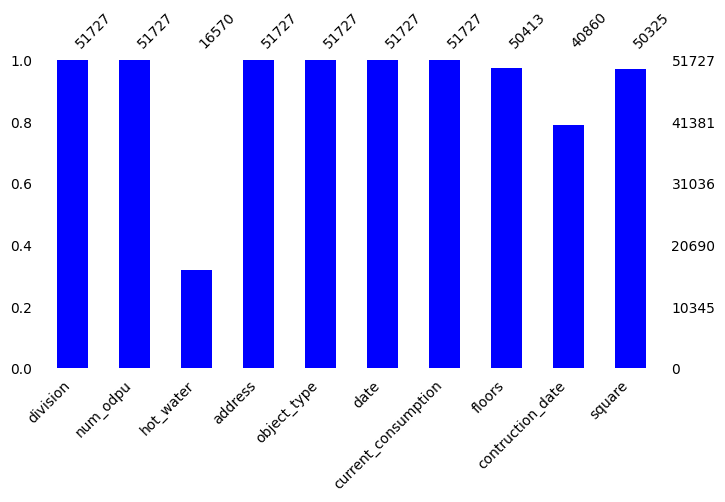

In [ ]:
msno.bar(df, color="blue", figsize=(8, 4), fontsize=10)

In [ ]:
print(f"Количество дубликатов: {df[df.duplicated()].shape[0]}")

Количество дубликатов: 0


В данных встречаются адреса: респ Башкортостан, г Уфа и тракт. Бирский.
Думаю, их можно удалить.

In [ ]:
df[df.address=="респ Башкортостан"].num_odpu.unique()

array(['595', '596'], dtype=object)

In [ ]:
df[df.address=='г Уфа'].num_odpu.unique()

array(['787'], dtype=object)

In [ ]:
# тут можно посмотреть данные по этим адресам.
# df[df.address == 'г Уфа'].sort_values('date')
# df[df.address == 'респ Башкортостан'].sort_values('date')
# df[df.address == 'г Уфа, тракт. Бирский'].sort_values('date')
df = df[
    (df.address != "г Уфа")
    & (df.address != "респ Башкортостан")
    & (df.address != "г Уфа, тракт. Бирский")
]

Посмотрим на данные по адресам с 2 ОДПУ.

In [ ]:
df[df['address'].isin(addess_with_2odpu)].sort_values(['address', 'date'])

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square
33093,Уфа,219785,ГВС-ИТП,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-10-01,39.780,9,1981-01-01 00:00:00,9474.30
26688,Уфа,219785,ГВС-ИТП,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-11-01,106.660,9,1981-01-01 00:00:00,9474.30
28562,Уфа,032329,NaN,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-11-01,6.608,9,1981-01-01 00:00:00,9474.30
17825,Уфа,219785,ГВС-ИТП,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-12-01,183.153,9,1981-01-01 00:00:00,9474.30
20639,Уфа,032329,NaN,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-12-01,12.494,9,1981-01-01 00:00:00,9474.30
...,...,...,...,...,...,...,...,...,...,...
43336,Уфа,222546,NaN,"г Уфа, ул. Энтузиастов, д.20",Другое строение,2023-03-01,294.417,4,NaN,0.01
43337,Уфа,126313,ГВС-ИТП,"г Уфа, ул. Энтузиастов, д.20",Другое строение,2023-03-01,1132.480,4,NaN,0.01
16441,Уфа,126313,ГВС-ИТП,"г Уфа, ул. Энтузиастов, д.20",Другое строение,2023-04-01,789.375,4,NaN,0.01
16442,Уфа,126310,ГВС-ИТП,"г Уфа, ул. Энтузиастов, д.20",Другое строение,2023-04-01,879.841,4,NaN,0.01


**Вывод**: надо рассматривать каждый счетчик по адресу, нельзя их объединить.

In [ ]:
df.contruction_date = pd.to_numeric(
    df.contruction_date.astype(str).str[:4], errors="coerce", downcast="integer"
)
df.contruction_date = df.contruction_date.fillna(-1)

In [ ]:
construction_NaN = df[
    (df.contruction_date == -1) & (~df.address.str.contains("Подобъект|Подъезд"))
].sort_values(["address", "date"])
construction_NaN

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square
27380,Уфа,237959,NaN,"г Уфа, б-р. Баландина, д.2а",Другое строение,2021-11-01,7.288,3,-1.0,0.00
19841,Уфа,237959,NaN,"г Уфа, б-р. Баландина, д.2а",Другое строение,2021-12-01,17.911,3,-1.0,0.00
38615,Уфа,237959,NaN,"г Уфа, б-р. Баландина, д.2а",Другое строение,2022-03-01,26.315,3,-1.0,0.00
10470,Уфа,237959,NaN,"г Уфа, б-р. Баландина, д.2а",Другое строение,2022-04-01,24.151,3,-1.0,0.00
28729,Уфа,237959,NaN,"г Уфа, б-р. Баландина, д.2а",Другое строение,2022-11-01,7.196,3,-1.0,0.00
...,...,...,...,...,...,...,...,...,...,...
24798,Уфа,1981,NaN,"р-н Уфимский, д Лекаревка",Другое строение,2022-12-01,165.000,1,-1.0,0.01
8296,Уфа,1981,NaN,"р-н Уфимский, д Лекаревка",Другое строение,2023-01-01,230.000,1,-1.0,0.01
51726,Уфа,1981,NaN,"р-н Уфимский, д Лекаревка",Другое строение,2023-02-01,238.000,1,-1.0,0.01
43466,Уфа,1981,NaN,"р-н Уфимский, д Лекаревка",Другое строение,2023-03-01,190.000,1,-1.0,0.01


In [ ]:
construction_NaN.object_type.value_counts()

object_type
Другое строение                                              9253
Дет.ясли и сады                                               117
Многоквартирный дом                                           110
Административные здания, конторы                               64
Школы и ВУЗ                                                    60
Магазины                                                       39
Спортзалы, крытые стадионы и другие спортивные сооружения      13
Нежилой дом                                                    13
Пожарное депо                                                   7
Гаражи                                                          5
Name: count, dtype: int64

В данном случае мы можем дополнить данные только Многоквартирный дом

In [ ]:
set(construction_NaN[construction_NaN.object_type == "Многоквартирный дом"].address)

{'г Уфа, б-р. Ибрагимова, д.90 корп.2',
 'г Уфа, ул. Ахметова, д.304 корп.2',
 'г Уфа, ул. Владивостокская, д.10 корп.3,4',
 'г Уфа, ул. Кремлевская, д.50 корп.2',
 'г Уфа, ул. Кремлевская, д.66',
 'г Уфа, ул. Лесотехникума, д.21',
 'г Уфа, ул. Нежинская, д.27',
 'г Уфа, ул. Пекинская, д.23',
 'г Уфа, ул. Рихарда Зорге, д.70 корп.1',
 'г Уфа, ул. Рудольфа Нуреева, д.5',
 'г Уфа, ул. Уфимское шоссе, д.24 корп.1',
 'г Уфа, ул. Уфимское шоссе, д.4',
 'г Уфа, ул. Ферина, д.7'}

In [ ]:
data = {
    "г Уфа, б-р. Ибрагимова, д.90 корп.2": 2023,
    "г Уфа, ул. Ахметова, д.304 корп.2": 1988,
    "г Уфа, ул. Владивостокская, д.10 корп.3,4": 2015,
    "г Уфа, ул. Кремлевская, д.50 корп.2": 2021,
    "г Уфа, ул. Кремлевская, д.66": 2020,
    "г Уфа, ул. Лесотехникума, д.21": 2020,
    "г Уфа, ул. Нежинская, д.27": 2020,
    "г Уфа, ул. Пекинская, д.23": 2020,
    "г Уфа, ул. Рихарда Зорге, д.70 корп.1": 2003,
    "г Уфа, ул. Рудольфа Нуреева, д.5": 2023,
    "г Уфа, ул. Уфимское шоссе, д.24 корп.1": 2021,
    "г Уфа, ул. Уфимское шоссе, д.4": 1976,
    # 'г Уфа, ул. Ферина, д.7':
}

In [ ]:
constr_dates = pd.DataFrame(list(data.items()), columns=["address", "date_real"])
constr_dates

,address,date_real
0,"г Уфа, б-р. Ибрагимова, д.90 корп.2",2023
1,"г Уфа, ул. Ахметова, д.304 корп.2",1988
2,"г Уфа, ул. Владивостокская, д.10 корп.3,4",2015
3,"г Уфа, ул. Кремлевская, д.50 корп.2",2021
4,"г Уфа, ул. Кремлевская, д.66",2020
5,"г Уфа, ул. Лесотехникума, д.21",2020
6,"г Уфа, ул. Нежинская, д.27",2020
7,"г Уфа, ул. Пекинская, д.23",2020
8,"г Уфа, ул. Рихарда Зорге, д.70 корп.1",2003
9,"г Уфа, ул. Рудольфа Нуреева, д.5",2023


In [ ]:
df = df.merge(constr_dates, on="address", how="left")


df["contruction_date"] = df.apply(
    lambda row: (
        row["date_real"] if row["contruction_date"] == -1 else row["contruction_date"]
    ),
    axis=1,
)

In [ ]:
df.drop(columns=['date_real'], inplace=True)
df.contruction_date = df.contruction_date.fillna(-1)

In [ ]:
len(
    set(
        df[
            (df.contruction_date == -1)
            # & (~df.address.str.contains("Подобъект|Подъезд"))
        ].address
    )
)

862

И вопрос возникает, как может быть 0 этажей?\
Выведем список этих адресов.

In [ ]:
df[df.floors == 0].address.unique()

array(['г Уфа, ул. Львовская, д.4', 'г Уфа, пл. Верхнеторговая, д.1.',
       'г Уфа, ул. Рихарда Зорге, д.19 корп.1',
       'г Уфа, ул. Крупской, д.9'], dtype=object)

Найдем этажность по адресам с 0 этажей.

In [ ]:
data = {
    "г Уфа, пл. Верхнеторговая, д.1.": 2,
    "г Уфа, ул. Львовская, д.4": 2,
    "г Уфа, ул. Крупской, д.9": 13,
    "г Уфа, ул. Рихарда Зорге, д.19 корп.1": 3,
}

Попробуем заменить пропуски.

In [ ]:
floors = pd.DataFrame(list(data.items()), columns=['address', 'floors_real'])

In [ ]:
floors

,address,floors_real
0,"г Уфа, пл. Верхнеторговая, д.1.",2
1,"г Уфа, ул. Львовская, д.4",2
2,"г Уфа, ул. Крупской, д.9",13
3,"г Уфа, ул. Рихарда Зорге, д.19 корп.1",3


In [ ]:
df = df.merge(floors, on='address', how='left')

df['floors'] = df.apply(
    lambda row: row['floors_real'] if row['floors'] == 0 else row['floors'],
    axis=1
)

In [ ]:
df.drop(columns=['floors_real'], inplace=True)

Посмотрим пропуски по этажам и площади.\
Все пропуски по этажам повторяются и в площади.

In [ ]:
print(
    f"Адресов, где нет этажа и площади: {len(set(df[(df.floors.isna()) & (df.square.isna())].address))}"
)
print(
    f"Адресов, где нет этажа и площади (содержащие Подобъект|Подъезд): {len(set(df[(df.floors.isna()) & (df.square.isna())& (df.address.str.contains('Подобъект|Подъезд'))].address))}"
)

Адресов, где нет этажа и площади: 141
Адресов, где нет этажа и площади (содержащие Подобъект|Подъезд): 128


In [ ]:
set(df[(~df.floors.isna() & (df.square.isna()))].address)

{'г Уфа, пр-кт Октября, д.149',
 'г Уфа, ул. Георгия Мушникова, д.13',
 'г Уфа, ул. Кислородная, д.10 корп.А',
 'г Уфа, ул. Первомайская, д.44 корп.А',
 'г Уфа, ул. Революционная, д.98 корп.2',
 'г Уфа, ул. Рихарда Зорге, д.19',
 'г Уфа, ул. Рихарда Зорге, д.3',
 'г Уфа, ул. Сельская Богородская, д.37'}

В пропусках у нас есть:
- адреса, содержащие Подобъект|Подъезд
- обычные адреса

In [ ]:
df[(~df.address.str.contains('Подобъект|Подъезд')) & (df.floors.isna())].sort_values(['address', 'date'])

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square
21565,Уфа,00254506,NaN,"г Уфа, ул. Ахметова, д.322, Гаражи (ЧЖД) №987001",Гаражи,2022-12-01,2.731,NaN,-1.0,NaN
5045,Уфа,00254506,NaN,"г Уфа, ул. Ахметова, д.322, Гаражи (ЧЖД) №987001",Гаражи,2023-01-01,7.215,NaN,-1.0,NaN
48444,Уфа,00254506,NaN,"г Уфа, ул. Ахметова, д.322, Гаражи (ЧЖД) №987001",Гаражи,2023-02-01,8.009,NaN,-1.0,NaN
40185,Уфа,00254506,NaN,"г Уфа, ул. Ахметова, д.322, Гаражи (ЧЖД) №987001",Гаражи,2023-03-01,6.197,NaN,-1.0,NaN
13314,Уфа,00254506,NaN,"г Уфа, ул. Ахметова, д.322, Гаражи (ЧЖД) №987001",Гаражи,2023-04-01,3.935,NaN,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...
16326,Уфа,477076,NaN,"г Уфа, ул. Шафиева, д.2",Другое строение,2023-04-01,123.700,NaN,-1.0,NaN
16327,Уфа,477056,NaN,"г Уфа, ул. Шафиева, д.2",Другое строение,2023-04-01,26.170,NaN,-1.0,NaN
16328,Уфа,477171,NaN,"г Уфа, ул. Шафиева, д.2",Другое строение,2023-04-01,260.030,NaN,-1.0,NaN
16329,Уфа,476951,NaN,"г Уфа, ул. Шафиева, д.2",Другое строение,2023-04-01,7.540,NaN,-1.0,NaN


Заполнить данные пропуски не возможно из-за недостатка информации в файле с данными по объектам.

Cделаем hot_water булевым.

In [ ]:
df.hot_water = df.hot_water.fillna(0).replace('ГВС-ИТП', 1)

In [ ]:
df.hot_water.value_counts()

hot_water
0    35141
1    16542
Name: count, dtype: int64

Попробуем убрать оставшиеся пропуски по МКД.

In [ ]:
df[df.object_type == 'Многоквартирный дом'].isna().sum()

division                 0
num_odpu                 0
hot_water                0
address                  0
object_type              0
date                     0
current_consumption      0
floors                 569
contruction_date         0
square                 569
dtype: int64

In [ ]:
(
    df[
        (df.object_type == "Многоквартирный дом")
        & df.floors.isna()
        & (~df.address.str.contains("Подобъект|Подъезд"))
    ]
).address

89                  г Уфа, ул. Уфимское шоссе, д.4
8691                г Уфа, ул. Уфимское шоссе, д.4
16640               г Уфа, ул. Уфимское шоссе, д.4
24891               г Уфа, ул. Уфимское шоссе, д.4
35196    г Уфа, ул. Владивостокская, д.10 корп.3,4
35224               г Уфа, ул. Уфимское шоссе, д.4
43753               г Уфа, ул. Уфимское шоссе, д.4
Name: address, dtype: object

In [ ]:
df.loc[df.address == 'г Уфа, ул. Уфимское шоссе, д.4','floors'] = 9
df.loc[df.address == 'г Уфа, ул. Уфимское шоссе, д.4','contruction_date'] = 1976
df.loc[df.address == 'г Уфа, ул. Владивостокская, д.10 корп.3,4','floors'] = 12
df.loc[df.address == 'г Уфа, ул. Владивостокская, д.10 корп.3,4','contruction_date'] = 2015

<Axes: >

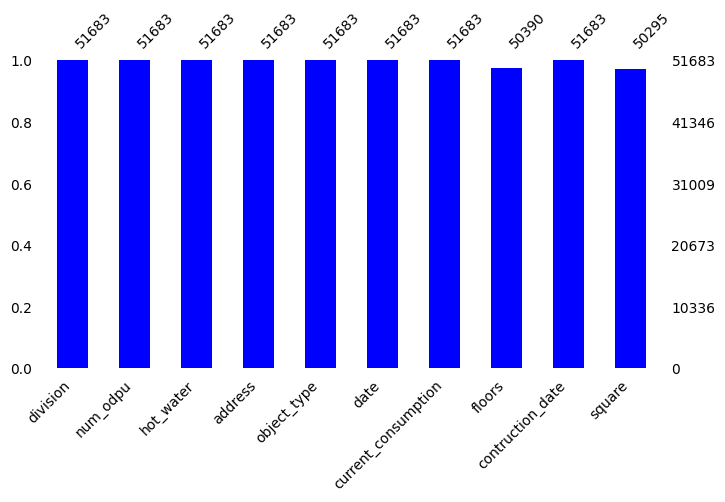

In [ ]:
msno.bar(df, color="blue", figsize=(8, 4), fontsize=10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51683 entries, 0 to 51682
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   division             51683 non-null  object        
 1   num_odpu             51683 non-null  object        
 2   hot_water            51683 non-null  object        
 3   address              51683 non-null  object        
 4   object_type          51683 non-null  object        
 5   date                 51683 non-null  datetime64[ns]
 6   current_consumption  51683 non-null  float64       
 7   floors               50390 non-null  float64       
 8   contruction_date     51683 non-null  float64       
 9   square               50295 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 3.9+ MB


#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Температуры</div>

In [ ]:
temperature

,Unnamed: 0,Период,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00,2021-10-01 00:00:00,2021-11-01 00:00:00,2021-12-01 00:00:00,2022-01-01 00:00:00,2022-02-01 00:00:00,...,2022-09-01 00:00:00,2022-10-01 00:00:00,2022-11-01 00:00:00,2022-12-01 00:00:00,2023-01-01 00:00:00,2023-02-01 00:00:00,2023-03-01 00:00:00,2023-04-01 00:00:00,2023-05-01 00:00:00,2023-06-01 00:00:00
0,NaN,"Тн.в, град.С",NaN,NaN,NaN,6.696552,-1.0,-5.176667,-11.5,-6.735714,...,NaN,7.137037,-1.606452,-10.903333,-12.745161,-8.944828,-2.266667,7.81875,NaN,NaN
1,NaN,"Продолжительность ОЗП, сут.",NaN,NaN,NaN,29.000000,31.0,30.000000,31.0,28.000000,...,NaN,27.000000,31.000000,30.000000,31.000000,29.000000,30.000000,32.00000,NaN,NaN


In [ ]:
temperature.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
temperature = temperature.set_index('Период').T

In [ ]:
temperature = temperature.reset_index()

In [ ]:
temperature

Период,index,"Тн.в, град.С","Продолжительность ОЗП, сут."
0,2021-07-01,NaN,NaN
1,2021-08-01,NaN,NaN
2,2021-09-01,NaN,NaN
3,2021-10-01,6.696552,29.0
4,2021-11-01,-1.000000,31.0
5,2021-12-01,-5.176667,30.0
6,2022-01-01,-11.500000,31.0
7,2022-02-01,-6.735714,28.0
8,2022-03-01,-5.151613,31.0
9,2022-04-01,5.650000,34.0


Удалим месяцы без отопления.

In [ ]:
temperature = temperature[~temperature['index'].dt.month.isin(months)]

In [ ]:
df['period'] = df['date'].apply(lambda x: str(x.month) + str(x.year))
temperature['period'] = temperature['index'].apply(lambda x: str(x.month) + str(x.year))

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_1640\2863288034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature['period'] = temperature['index'].apply(lambda x: str(x.month) + str(x.year))


In [ ]:
df = df.merge(temperature, on='period')

In [ ]:
df.rename(
    columns={"Тн.в, град.С": "temperature", "Продолжительность ОЗП, сут.": "ozp"},
    inplace=True,
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51683 entries, 0 to 51682
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   division             51683 non-null  object        
 1   num_odpu             51683 non-null  object        
 2   hot_water            51683 non-null  object        
 3   address              51683 non-null  object        
 4   object_type          51683 non-null  object        
 5   date                 51683 non-null  datetime64[ns]
 6   current_consumption  51683 non-null  float64       
 7   floors               50390 non-null  float64       
 8   contruction_date     51683 non-null  float64       
 9   square               50295 non-null  float64       
 10  period               51683 non-null  object        
 11  index                51683 non-null  datetime64[ns]
 12  temperature          51683 non-null  float64       
 13  ozp                  51683 non-

Проверим, есть ли пропуски по месяцам с отоплением.

In [ ]:
df[df.ozp.isna()].period.value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
df.drop(columns=['period', 'index'], inplace=True)

Нулевые значения показаний за тепловую энергию в отопительный период (октябрь-апрель).

In [ ]:
df[(df.current_consumption == 0) & (df.hot_water != 1)]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp
4015,Уфа,18-028134,0,"г Уфа, ул. Маршала Жукова, д.1/2, Подобъект №984860",Многоквартирный дом,2022-01-01,0.0,NaN,-1.0,NaN,-11.500000,31.0
20113,Уфа,01329161850,0,"г Уфа, ул. Рудольфа Нуреева, д.1 корп.1-3",Многоквартирный дом,2021-12-01,0.0,20.0,2019.0,26756.30,-5.176667,30.0
27995,Уфа,2300 N CF944,0,"г Уфа, ул. Трамвайная, д.3",Другое строение,2021-10-16,0.0,3.0,-1.0,0.01,6.696552,29.0
28670,Уфа,17470191,0,"г Уфа, ул. Комсомольская, д.15, Подобъект №35951",Многоквартирный дом,2021-11-01,0.0,NaN,-1.0,NaN,-1.000000,31.0
30975,Уфа,16030038,0,"г Уфа, ул. Маршала Жукова, д.3 корп.1",Многоквартирный дом,2022-11-01,0.0,14.0,2007.0,16038.70,-1.606452,31.0
32952,Уфа,88978,0,"г Уфа, ул. Первомайская, д.58",Многоквартирный дом,2021-10-01,0.0,5.0,1962.0,3173.60,6.696552,29.0
33770,Уфа,00218347,0,"г Уфа, ул. Рихарда Зорге, д.23 корп.1",Другое строение,2021-10-01,0.0,2.0,1964.0,0.01,6.696552,29.0
33801,Уфа,00218507,0,"г Уфа, ул. Рихарда Зорге, д.23 корп.1",Другое строение,2021-10-01,0.0,2.0,1964.0,0.01,6.696552,29.0
45277,Уфа,18-028134,0,"г Уфа, ул. Маршала Жукова, д.1/2, Подобъект №984860",Многоквартирный дом,2022-02-01,0.0,NaN,-1.0,NaN,-6.735714,28.0


Нулевые значения показаний есть по сути отклонением от потребления за аналогичный период предыдущего года. Решим в дальнейшем через формирование признака разницы потребления.

# <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Генерация новых признаков</div>

In [ ]:
data_df = df.copy()

In [ ]:
data_df.head(2)

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp
0,Уфа,"467, 18067553, 18067558",0,"г Уфа, ул. Рудольфа Нуреева, д.1 корп.1-3",Многоквартирный дом,2022-04-01,506.9364,20.0,2019.0,26756.3,5.65000,34.0
1,Уфа,89612 89617,0,"г Уфа, ул. Даута Юлтыя, д.12",Многоквартирный дом,2023-04-01,375.3240,16.0,2011.0,13465.5,7.81875,32.0


нулевые значения показаний за тепловую энергию в отопительный период (октябрь-апрель)

In [ ]:
data_df[(data_df.current_consumption == 0) & (data_df.hot_water != 'ГВС-ИТП')].shape[0]

17

Месяц и день в качестве отдельного признака нужны дня группировки и в качестве дополнительного признака.

In [ ]:
data_df.date = pd.to_datetime(data_df.date)
data_df['year'] = data_df['date'].dt.year
data_df['month'] = data_df['date'].dt.month
data_df.date = data_df.date.dt.date

In [ ]:
# нет необходимость выделять больше памяти под целое число малой длины (влияет на скорость обучения)
data_df['contruction_date'] = data_df['contruction_date'].astype('Int16')
data_df['year'] = data_df['year'].astype('Int16')
data_df['month'] = data_df['month'].astype('Int8')
data_df['ozp'] = data_df['ozp'].astype('Int8')
data_df.floors = data_df.floors.astype('Int8')

Разделим дату постройки и этажность на группы.

In [ ]:
data_df['const_date_group'] = pd.cut(data_df['contruction_date'],
                                    bins=[-1,0, 1958, 1989, 2000, 2010, 2024],
                                    labels=['-1','<=1958', '1959-1989', '1990-2000', '2001-2010', '2011-2024'],
                                    include_lowest=True)

data_df['floors_group'] = pd.cut(data_df['floors'],
                                bins=[0, 2, 4, 9, 12, float('inf')],
                                labels=['1-2', '3-4', '5-9', '10-12', '>=13'],
                                include_lowest=True)

In [ ]:
data_df.square.fillna(-1, inplace=True)

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_1640\4016991739.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df.square.fillna(-1, inplace=True)


#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Разница в потреблении объекта в отношении к средней потребления по группе согласно пунктам 1 и 2</div>

In [ ]:
def calculate_deviation(group):
    """Функция для расчета отклонения в группе и записи в новый столбец"""
    group["cons_deviation"] = (
        abs(
            (group["current_consumption"] - group["current_consumption"].mean())
            / group["current_consumption"].mean()
        )
        * 100
    )
    return group

# data_df = data_df.groupby(['year','month', 'object_type', 'const_date_group', 'floors_group']).apply(calculate_deviation)
data_df = (
     data_df.groupby(["year", "month", "object_type", "const_date_group", "floors_group"])
    .apply(calculate_deviation)
    .reset_index(drop=True)
)

data_df.cons_deviation = round(data_df.cons_deviation,0)
data_df.cons_deviation.fillna(0, inplace=True)
data_df.cons_deviation =data_df.cons_deviation.astype(int)


C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_1640\1615350222.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_df.groupby(["year", "month", "object_type", "const_date_group", "floors_group"])
C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_1640\1615350222.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_deviation)
C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_1640\1615350222.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through

In [ ]:
data_df[(data_df.cons_deviation > 25)].shape[0]

31278

In [ ]:
data_df.cons_deviation.value_counts()

cons_deviation
21      911
25      897
18      876
20      864
26      854
       ... 
5130      1
861       1
1068      1
299       1
731       1
Name: count, Length: 598, dtype: int64

In [ ]:
data_df['test'] = round(data_df['cons_deviation'],0)

In [ ]:
print(data_df.cons_deviation.nunique())
print(data_df.test.nunique())

598
598


In [ ]:
data_df.drop('test', axis=1, inplace=True)

In [ ]:
data_df[data_df.cons_deviation.isna()]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation


In [ ]:
data_df.cons_deviation.fillna(0, inplace=True)

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_1640\3354787044.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df.cons_deviation.fillna(0, inplace=True)


In [ ]:
data_df.cons_deviation.describe()

count    50390.000000
mean        49.883370
std        112.538422
min          0.000000
25%         18.000000
50%         33.000000
75%         59.000000
max       5130.000000
Name: cons_deviation, dtype: float64

Есть значения с разницей потребления в 100%, посмотрим на них

In [ ]:
data_df[(data_df.cons_deviation == 100)]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation
183,Уфа,2300 N CF944,0,"г Уфа, ул. Трамвайная, д.3",Другое строение,2021-10-16,0.000,3,-1,0.01,6.696552,29,2021,10,-1,3-4,100
208,Уфа,22177396,1,"г Уфа, ул. Ленина, д.50",Другое строение,2021-10-01,0.000,3,-1,0.01,6.696552,29,2021,10,-1,3-4,100
309,Уфа,27834,1,"г Уфа, б-р. Ибрагимова, д.61",Другое строение,2021-10-01,0.000,5,-1,0.01,6.696552,29,2021,10,-1,5-9,100
351,Уфа,00218347,0,"г Уфа, ул. Рихарда Зорге, д.23 корп.1",Другое строение,2021-10-01,0.000,2,1964,0.01,6.696552,29,2021,10,1959-1989,1-2,100
353,Уфа,00218507,0,"г Уфа, ул. Рихарда Зорге, д.23 корп.1",Другое строение,2021-10-01,0.000,2,1964,0.01,6.696552,29,2021,10,1959-1989,1-2,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47144,Уфа,64006,1,"г Уфа, ул. Комсомольская, д.31 корп.2",Другое строение,2023-04-01,99.280,2,1987,0.01,7.818750,32,2023,4,1959-1989,1-2,100
47715,Уфа,72517,0,"г Уфа, б-р. Тухвата Янаби, д.49 корп.3",Многоквартирный дом,2023-04-01,196.876,9,1978,7507.50,7.818750,32,2023,4,1959-1989,5-9,100
50343,Уфа,01629181922,0,"г Уфа, ул. Рудольфа Нуреева, д.1 корп.1-3",Многоквартирный дом,2023-04-01,0.398,20,2019,26756.30,7.818750,32,2023,4,2011-2024,>=13,100
50344,Уфа,01330161850,0,"г Уфа, ул. Рудольфа Нуреева, д.1 корп.1-3",Многоквартирный дом,2023-04-01,1.200,20,2019,26756.30,7.818750,32,2023,4,2011-2024,>=13,100


Это значения с 0 показанием потребления

In [ ]:
count_deviation = data_df[(data_df['cons_deviation'] > 25)].groupby('object_type')['cons_deviation'].count()
print(count_deviation)

object_type
Административные здания, конторы          31
Групповая станция смешения                12
Дет.ясли и сады                           85
Другое строение                        10027
Жилое здание (Гостиница, Общежитие)       66
Интернат                                  24
Магазины                                  22
Многоквартирный дом                    20915
Нежилой дом                                6
Учебное заведение, комбинат, центр        37
Школы и ВУЗ                               53
Name: cons_deviation, dtype: int64


In [ ]:
count_deviation = data_df[(data_df['cons_deviation'] > 25)  & (data_df['contruction_date'] !=-1)].groupby('object_type')['cons_deviation'].count()
print(count_deviation)

object_type
Административные здания, конторы           4
Групповая станция смешения                12
Дет.ясли и сады                           33
Другое строение                         2283
Жилое здание (Гостиница, Общежитие)       66
Интернат                                  24
Многоквартирный дом                    20915
Учебное заведение, комбинат, центр        37
Школы и ВУЗ                               23
Name: cons_deviation, dtype: int64


count_deviation на настоящий момент самый сомнительный признак, либо предложенная группировка не адекватна

In [ ]:
data_df[data_df.square == 0].shape[0]

195

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Изменение площади объекта относительно прошлого наблюдения </div>

In [ ]:
data_df['area_deviation'] = data_df.groupby(['address','object_type'])['square'].pct_change()

In [ ]:
# т.к. метод pct_change() сравнивает с предыдущей строкой, то у первого объекта в группе будет значение NaN. Заменим на 0
if data_df['address'].nunique() > 1:
    data_df.loc[data_df['area_deviation'].isna(), 'area_deviation'] = 0

# т.к. в ряде случаем площадь объекта указана как 0, то в ряде случаев (~300) возвращает inf. Заменим на 0
data_df['area_deviation'] = data_df['area_deviation'].replace([float('inf'), -float('inf')], -1)

# округлим до сотых
data_df['area_deviation'] = round(data_df['area_deviation'],2)

In [ ]:
data_df.area_deviation.value_counts()

area_deviation
0.0    50390
Name: count, dtype: int64

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> Изменение потребления относительно того же месяца предшествующего периода (например октябрь 2021 к октябрю 2022)</div>

In [ ]:
data_df = data_df.sort_values(by=['address','num_odpu','year','month'])
data_df['year_per_year_cons_devi'] = round(abs(data_df.groupby('address')['current_consumption'].pct_change(periods = 7)*100))

# т.к. метод pct_change() сравнивает с предыдущей строкой, то у первого объекта в группе будет значение NaN. Заменим на 0
if data_df['address'].nunique() > 1:
    data_df.loc[data_df['year_per_year_cons_devi'].isna(), 'year_per_year_cons_devi'] = 0

# т.к. в ряде случаем площадь объекта указана как 0, то в ряде случаев (~300) возвращает inf. Заменим на 0
data_df['year_per_year_cons_devi'] = data_df['year_per_year_cons_devi'].replace([float('inf'), -float('inf')], 0)

data_df['year_per_year_cons_devi'] = data_df['year_per_year_cons_devi'].astype(int)

In [ ]:
data_df.year_per_year_cons_devi.value_counts()

year_per_year_cons_devi
0      27857
17       636
16       620
13       608
15       605
       ...  
337        1
819        1
677        1
688        1
521        1
Name: count, Length: 927, dtype: int64

In [ ]:
data_df[data_df.year_per_year_cons_devi > 25].shape[0]

10351

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">равные значения показаний в течение нескольких расчетных периодов</div>

In [ ]:
data_df['is_same_as_previous'] = (data_df['current_consumption'] == data_df['current_consumption'].shift(1)).astype(int)

In [ ]:
data_df.is_same_as_previous.value_counts()

is_same_as_previous
0    50352
1       38
Name: count, dtype: int64

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> Потенциальные таргеты</div>

In [ ]:
count_deviation = data_df[data_df['is_same_as_previous'] > 0].groupby('object_type')['cons_deviation'].count()
print(count_deviation)

object_type
Другое строение        17
Многоквартирный дом    21
Name: cons_deviation, dtype: int64


In [ ]:
count_deviation = data_df[data_df['year_per_year_cons_devi'] > 0].groupby('object_type')['cons_deviation'].count()
print(count_deviation)

object_type
Административные здания, конторы                                41
Групповая станция смешения                                       5
Дет.ясли и сады                                                 76
Другое строение                                               5685
Жилое здание (Гостиница, Общежитие)                             55
Интернат                                                        19
Казармы и помещения ВОХР                                         7
Магазины                                                        15
Многоквартирный дом                                          16523
Нежилой дом                                                      6
Спортзалы, крытые стадионы и другие спортивные сооружения        6
Учебное заведение, комбинат, центр                              36
Школы и ВУЗ                                                     59
Name: cons_deviation, dtype: int64


In [ ]:
count_deviation = data_df[data_df['area_deviation'] > 0].groupby('object_type')['cons_deviation'].count()
print(count_deviation)

Series([], Name: cons_deviation, dtype: int64)


In [ ]:
data_df[(data_df['is_same_as_previous'] > 0) & (data_df['year_per_year_cons_devi'] > 0) & (data_df['area_deviation'] > 0)].shape[0]

0

**Нет не одного события удовлетворяющего всем трем условиям**  
Нужно определять по отдельности

In [ ]:
data_df[(data_df['is_same_as_previous'] > 0) & (data_df['year_per_year_cons_devi'] > 0)].shape[0]

9

In [ ]:
data_df[(data_df['is_same_as_previous'] > 0) & (data_df['area_deviation'] > 0)].shape[0]

0

In [ ]:
data_df[(data_df['year_per_year_cons_devi'] > 0) & (data_df['area_deviation'] > 0)].shape[0]

0

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Дополнительные синтетические признаки</div>


#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">потребление на градус</div>

Показывает, сколько единиц текущего потребления приходится на один градус температуры, независимо от знака.

Можно использовать для выявления аномальных значений, где потребление резко увеличивается или уменьшается при небольших изменениях температуры. Это может указывать на проблемы в системе или на необычные условия.

In [ ]:
data_df['cons_per_deg'] = abs(data_df['current_consumption'] / data_df['temperature'])

In [ ]:
data_df.head(2)

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,...,ozp,year,month,const_date_group,floors_group,cons_deviation,area_deviation,year_per_year_cons_devi,is_same_as_previous,cons_per_deg
1322,Уфа,00119540,1,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2021-10-01,30.908,18,2011,5394.5,...,29,2021,10,2011-2024,>=13,46,0.0,0,0,4.61551
5155,Уфа,00119540,1,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2021-11-01,102.740,18,2011,5394.5,...,31,2021,11,2011-2024,>=13,39,0.0,0,0,102.74000


In [ ]:
data_df.cons_per_deg.describe()

count    50390.000000
mean        26.741473
std         60.908866
min          0.000000
25%          8.045838
50%         15.217237
75%         30.463536
max       5057.016176
Name: cons_per_deg, dtype: float64

In [ ]:
data_df[data_df.cons_per_deg > 5057]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,...,ozp,year,month,const_date_group,floors_group,cons_deviation,area_deviation,year_per_year_cons_devi,is_same_as_previous,cons_per_deg
42884,Уфа,2300 N CF944,0,"г Уфа, ул. Трамвайная, д.3",Другое строение,2023-03-01,11462.57,3,-1,0.01,...,30,2023,3,-1,3-4,4304,0.0,13,0,5057.016176


#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">температурный коэффициент</div>

In [ ]:
data_df.temperature.mean()

-3.8586192700251543

Представляет собой коэффициент, показывающий, как текущее потребление изменяется в зависимости от отклонения температуры от её среднего значения. Этот коэффициент может быть полезен для анализа зависимости потребления от температуры.

In [ ]:
data_df['temp_coef'] = data_df['current_consumption'] / (data_df['temperature'] - data_df['temperature'].mean())

In [ ]:
data_df.temp_coef.describe()

count    50390.000000
mean       -11.865915
std        103.624307
min      -7878.476536
25%        -29.454685
50%         -7.414869
75%         11.716843
max       7200.321150
Name: temp_coef, dtype: float64

In [ ]:
data_df[data_df.temp_coef < -7887]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,...,year,month,const_date_group,floors_group,cons_deviation,area_deviation,year_per_year_cons_devi,is_same_as_previous,cons_per_deg,temp_coef


In [ ]:
data_df[data_df.temp_coef > 1000]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,...,year,month,const_date_group,floors_group,cons_deviation,area_deviation,year_per_year_cons_devi,is_same_as_previous,cons_per_deg,temp_coef
42708,Уфа,21753,1,"г Уфа, проезд. Лесной, д.3",Другое строение,2023-03-01,2591.021,4,-1,0.12,...,2023,3,-1,3-4,896,0.0,0,0,1143.097500,1627.574210
43172,Уфа,20-106837,1,"г Уфа, ул. 50-летия Октября, д.34",Другое строение,2023-03-01,2244.594,2,1990,0.01,...,2023,3,1990-2000,1-2,1277,0.0,0,0,990.262059,1409.962831
42949,Уфа,71307,1,"г Уфа, ул. Карла Маркса, д.12",Другое строение,2023-03-01,2334.910,5,-1,0.01,...,2023,3,-1,5-9,1003,0.0,10,0,1030.107353,1466.695676
43272,Уфа,20-106826,1,"г Уфа, ул. Революционная, д.76",Казармы и помещения ВОХР,2023-03-01,1599.000,9,1980,9541.81,...,2023,3,1959-1989,5-9,0,0.0,18,0,705.441176,1004.426888
1863,Уфа,"CG166, CF944",0,"г Уфа, ул. Трамвайная",Другое строение,2021-11-01,3449.290,4,-1,0.01,...,2021,11,-1,3-4,3150,0.0,0,0,3449.290000,1206.627982
26702,Уфа,"CG166, CF944",0,"г Уфа, ул. Трамвайная",Другое строение,2022-11-01,3458.510,4,-1,0.01,...,2022,11,-1,3-4,3434,0.0,0,0,2152.887751,1535.636119
42879,Уфа,"CG166, CF944",0,"г Уфа, ул. Трамвайная",Другое строение,2023-03-01,9493.260,4,-1,0.01,...,2023,3,-1,3-4,3547,0.0,28,0,4188.202941,5963.280552
1927,Уфа,2300 N CF944,0,"г Уфа, ул. Трамвайная, д.3",Другое строение,2021-11-01,4539.370,3,-1,0.01,...,2021,11,-1,3-4,4177,0.0,0,0,4539.370000,1587.958931
21648,Уфа,2300 N CF944,0,"г Уфа, ул. Трамвайная, д.3",Другое строение,2022-04-01,11340.380,3,-1,0.01,...,2022,4,-1,3-4,5130,0.0,0,0,2007.146903,1192.642136
26705,Уфа,2300 N CF944,0,"г Уфа, ул. Трамвайная, д.3",Другое строение,2022-11-01,4407.430,3,-1,0.01,...,2022,11,-1,3-4,4404,0.0,3,0,2743.580924,1956.972424


**Кажется, что из этого коэффициента можно выжать больше, но пока непонимаю как**

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">среднее потребление за 3 месяца</div>

In [ ]:
data_df['avg_cons'] = data_df['current_consumption'].rolling(window=3).mean()
data_df.avg_cons.fillna(0, inplace=True)

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_1640\2596668361.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df.avg_cons.fillna(0, inplace=True)


In [ ]:
data_df.avg_cons.describe()

count    50390.000000
mean       119.181777
std        227.499876
min          0.000000
25%         59.988083
50%         89.514233
75%        131.244981
max      13662.850000
Name: avg_cons, dtype: float64

In [ ]:
data_df[data_df.avg_cons > 13662]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,...,month,const_date_group,floors_group,cons_deviation,area_deviation,year_per_year_cons_devi,is_same_as_previous,cons_per_deg,temp_coef,avg_cons
42884,Уфа,2300 N CF944,0,"г Уфа, ул. Трамвайная, д.3",Другое строение,2023-03-01,11462.57,3,-1,0.01,...,3,-1,3-4,4304,0.0,13,0,5057.016176,7200.32115,13662.85


#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">отклонение от среднего потребления</div>

In [ ]:
data_df['cons_dev'] = round(abs(((data_df['current_consumption'] - data_df['avg_cons'])/data_df['avg_cons'])*100),2)
data_df['cons_dev'] = data_df['cons_dev'].replace([float('inf'), -float('inf')], 0)
data_df.cons_dev.fillna(0, inplace=True)

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_1640\3865519323.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df.cons_dev.fillna(0, inplace=True)


In [ ]:
data_df.cons_dev.value_counts()

cons_dev
0.00      31
8.97      31
8.79      30
9.14      29
8.25      29
          ..
90.46      1
34.68      1
66.72      1
88.88      1
121.21     1
Name: count, Length: 9194, dtype: int64

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Лаг потребления Гкал за предыдущий месяц</div>

Для выявления аномальных изменений в потреблении.

In [ ]:
# Создаем столбец с предыдущим потреблением
data_df['prev_consumption'] = data_df.groupby(['address', 'num_odpu', 'year'])['current_consumption'].shift(1)

# Вычисляем разницу между текущим и предыдущим потреблением
data_df['consumption_diff'] = abs((data_df['current_consumption'] - data_df['prev_consumption']) / data_df['prev_consumption'])*100
data_df['consumption_diff'] = data_df['consumption_diff'].replace([float('inf'), -float('inf')], 0)
data_df.drop('prev_consumption', axis=1, inplace=True)
data_df.consumption_diff.fillna(0, inplace=True)

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_1640\189996227.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df.consumption_diff.fillna(0, inplace=True)


In [ ]:
data_df.consumption_diff.describe()

count     50390.000000
mean         63.835787
std        1858.018399
min           0.000000
25%           0.177720
50%          16.676116
75%          33.605494
max      393445.161290
Name: consumption_diff, dtype: float64

In [ ]:
data_df.consumption_diff.value_counts()

consumption_diff
0.000000      12453
51.459324         2
100.000000        2
42.914750         2
27.620684         2
              ...  
44.746027         1
55.136109         1
1.838879          1
15.329941         1
6.315789          1
Name: count, Length: 37929, dtype: int64

In [ ]:
data_df[data_df.consumption_diff > 25].shape[0]

17178

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Лаг температуры за предыдущий месяц</div>

In [ ]:
data_df['prev_temperature'] = data_df.groupby(['address', 'num_odpu', 'year'])['temperature'].shift(1)
data_df['temperature_diff'] = (data_df['temperature'] - data_df['prev_temperature']) / data_df['prev_temperature']
data_df['temperature_diff'] = data_df['temperature_diff'].replace([float('inf'), -float('inf')], 0)
data_df.drop('prev_temperature', axis=1, inplace=True)
data_df.temperature_diff.fillna(0, inplace=True)

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_1640\444595080.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df.temperature_diff.fillna(0, inplace=True)


In [ ]:
data_df.temperature_diff.value_counts()

temperature_diff
 0.000000    12428
-4.449449     4019
-0.746595     4011
-0.298179     3998
-2.096744     3923
-0.414286     3920
-0.235179     3919
 5.787216     3820
 4.176667     3802
-1.284328     2758
-1.149331     1395
-1.225087     1000
 0.263192      974
-2.929794      164
-0.552034       42
-0.822155       37
-0.688165       29
-1.838812       28
-1.874109       23
-2.527711       13
-2.385399       13
-0.761502       12
 1.116489       11
-1.613468       11
-1.491304       11
-1.773035       10
-0.860309        9
 0.618735        5
-0.051884        3
-1.620612        1
-2.059581        1
Name: count, dtype: int64

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Произведение потребления Гкал и температуры</div>

Если произведение сильно отличается, то аномалия. В целом признак нужен для усиления влияния потребления и температуры на решение модели.

In [ ]:
data_df['consumption_times_temperature'] = data_df['current_consumption'] * data_df['temperature']


In [ ]:
data_df.consumption_times_temperature.describe()

count     50390.000000
mean       -589.772854
std        2237.016590
min     -184173.061065
25%        -968.287476
50%        -343.425591
75%         -42.685000
max       64073.147000
Name: consumption_times_temperature, dtype: float64

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Разница между потреблением Гкал и температурой</div>

Тоже что и с предыдущим.

In [ ]:
data_df['consumption_minus_temperature'] = data_df['current_consumption'] - data_df['temperature']

In [ ]:
data_df.consumption_minus_temperature.describe()

count    50390.000000
mean       123.045097
std        244.076440
min         -7.420750
25%         54.800290
50%         93.148987
75%        139.696621
max      15084.494828
Name: consumption_minus_temperature, dtype: float64

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Выделение улицы из адреса</div>

In [ ]:
new_cols = (
    df["address"]
    .str.split(", ", expand=True)
    .rename(columns={0: "city", 1: "street", 2: "house", 3: "building"})
)
new_cols.drop(columns = ["house", "building"], axis=1,inplace=True)
# new_cols['building'] = new_cols['house'].str.split(' ', expand=True)[1]
# new_cols['house'] = new_cols['house'].str.split(' ', expand=True)[0]
# new_cols.fillna(0, inplace=True)

new_cols

,city,street
0,г Уфа,ул. Рудольфа Нуреева
1,г Уфа,ул. Даута Юлтыя
2,г Уфа,ул. Рудольфа Нуреева
3,г Уфа,ул. Рихарда Зорге
4,г Уфа,ул. Адмирала Макарова
...,...,...
51678,г Уфа,ул. Юрия Гагарина
51679,г Уфа,ул. Юрия Гагарина
51680,г Уфа,ул. Юрия Гагарина
51681,г Уфа,ул. Юрия Гагарина


In [ ]:
data_df = data_df.join(new_cols)

data_df.insert(3, 'city', data_df.pop('city'))
data_df.insert(4, 'street', data_df.pop('street'))
# data_df.insert(5, 'house', data_df.pop('house'))
# data_df.insert(6, 'building', data_df.pop('building'))
data_df.head(5)

,division,num_odpu,hot_water,city,street,address,object_type,date,current_consumption,floors,...,year_per_year_cons_devi,is_same_as_previous,cons_per_deg,temp_coef,avg_cons,cons_dev,consumption_diff,temperature_diff,consumption_times_temperature,consumption_minus_temperature
1322,Уфа,00119540,1,г Уфа,ул. Ферина,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2021-10-01,30.908,18,...,0,0,4.615510,2.928233,0.000000,0.00,0.000000,0.000000,206.977021,24.211448
5155,Уфа,00119540,1,г Уфа,ул. Блюхера,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2021-11-01,102.740,18,...,0,0,102.740000,35.940428,0.000000,0.00,232.405850,-1.149331,-102.740000,103.740000
9119,Уфа,00119540,1,г Уфа,б-р. Ибрагимова,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2021-12-01,222.965,18,...,0,0,43.071153,-169.163112,118.871000,87.57,117.018688,4.176667,-1154.215483,228.141667
13125,Уфа,00119540,1,г Уфа,ул. Адмирала Ушакова,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2022-01-01,183.898,18,...,0,0,15.991130,-24.066070,169.867667,8.26,0.000000,0.000000,-2114.827000,195.398000
17143,Уфа,00119540,1,г Уфа,ул. Вологодская,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2022-02-01,261.930,18,...,0,0,38.886744,-91.039746,222.931000,17.49,42.432218,-0.414286,-1764.285643,268.665714


In [ ]:
# data_df.insert(30, 'is_same_as_previous', data_df.pop('is_same_as_previous'))

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">фичи выбросов</div>

* Если разница в потреблении объекта в отношении к средней потребления по группе больше 25%, то относим к аномалии;

* Если изменение площади объекта относительно прошлого наблюдения больше 10%, то аномалия;

* Если изменение потребления относительно того же месяца предшествующего периода больше 25%, то аномалия;

* Если отклонение от среднего потребления больше 50%, то аномалия;


In [ ]:
data_df['cons_dev_anom'] = data_df['cons_deviation'].apply(lambda x: 1 if x > 25 else 0)
data_df['area_dev_anom'] = data_df['area_deviation'].apply(lambda x: 1 if x > 10 else 0)
data_df['ypy_cons_devi_anom'] = data_df['year_per_year_cons_devi'].apply(lambda x: 1 if x > 25 else 0)
data_df['cons_dev_anom'] = data_df['cons_dev'].apply(lambda x: 1 if x > 50 else 0)

In [ ]:
data_df.cons_dev_anom.value_counts()

cons_dev_anom
0    41949
1     8441
Name: count, dtype: int64

In [ ]:
data_df.area_dev_anom.value_counts()

area_dev_anom
0    50390
Name: count, dtype: int64

In [ ]:
data_df.ypy_cons_devi_anom.value_counts()

ypy_cons_devi_anom
0    40039
1    10351
Name: count, dtype: int64

In [ ]:
data_df.cons_dev_anom.value_counts()

cons_dev_anom
0    41949
1     8441
Name: count, dtype: int64

Сумма таргетов

In [ ]:
data_df['anom_sum'] = data_df.is_same_as_previous + data_df.cons_dev_anom + data_df.area_dev_anom + data_df.ypy_cons_devi_anom + data_df.cons_dev_anom

In [ ]:
data_df.anom_sum.value_counts()

anom_sum
0    33293
1     8648
2     6724
3     1725
Name: count, dtype: int64

Есть хотя бы одна аномалия

In [ ]:
data_df['anom'] = data_df['anom_sum'].apply(lambda x: 1 if x != 0 else 0)

In [ ]:
data_df.anom.value_counts()

anom
0    33293
1    17097
Name: count, dtype: int64

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Итоговой датасет для обучения</div>

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50390 entries, 1322 to 46772
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   division                       50390 non-null  object  
 1   num_odpu                       50390 non-null  object  
 2   hot_water                      50390 non-null  object  
 3   city                           50390 non-null  object  
 4   street                         50390 non-null  object  
 5   address                        50390 non-null  object  
 6   object_type                    50390 non-null  object  
 7   date                           50390 non-null  object  
 8   current_consumption            50390 non-null  float64 
 9   floors                         50390 non-null  Int8    
 10  contruction_date               50390 non-null  Int16   
 11  square                         50390 non-null  float64 
 12  temperature                    503

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Полный список новых признаков и примеры аномалий</div>

Новые основные:

* **cons_deviation** - разница в потреблении объекта в отношении к средней потребления по группе;
* **area_deviation** - изменение площади объекта относительно прошлого наблюдения;
* **year_per_year_cons_devi** - изменение потребления относительно того же месяца предшествующего периода;
*  **cons_per_deg** - потребление на градус;
* **temp_coef** - температурный коэффициент;
* **avg_cons** - среднее потребление за 3 месяца;
* **cons_dev** - отклонение от среднего потребления;
* **consumption_diff** - лаг потребления Гкал за предыдущий месяц;
* **temperature_diff** - лаг температуры за предыдущий месяц;
* **consumption_times_temperature** - произведение потребления Гкал и температуры;
* **consumption_minus_temperature** - разница между потреблением Гкал и температурой;

Таргеты:

* **is_same_as_previous** - равные значения показаний в течение нескольких расчетных периодов;
* **cons_dev_anom** - *cons_deviation* аномалия (True(1),False(0));
* **area_dev_anom** - *area_deviation* аномалия (True(1),False(0));
* **ypy_cons_devi_anom** - *year_per_year_cons_devi* аномалия (True(1),False(0));
* **cons_dev_anom** - *cons_dev* аномалия (True(1),False(0));
* **anom_sum** - сумма таргетов.
* **anom** - *anom_sum* аномалия (True(1),False(0)).


In [ ]:
print('Пример относительно нормальной:\n',data_df.loc[50000])

Пример относительно нормальной:
 division                                              Уфа
num_odpu                                         14014468
hot_water                                               1
city                                                г Уфа
street                                      ул. Мингажева
address                          г Уфа, ул. Сельская, д.9
object_type                           Многоквартирный дом
date                                           2023-04-01
current_consumption                               232.039
floors                                                  9
contruction_date                                     2001
square                                             8269.0
temperature                                       7.81875
ozp                                                    32
year                                                 2023
month                                                   4
const_date_group                       

In [ ]:
print('Пример аномалии:\n', data_df.loc[33947])

Пример аномалии:
 division                                                 Уфа
num_odpu                                            00119540
hot_water                                                  1
city                                                   г Уфа
street                                     ул. Рихарда Зорге
address                          г Уфа, б-р. Баландина, д.11
object_type                              Многоквартирный дом
date                                              2022-12-01
current_consumption                                  161.674
floors                                                    18
contruction_date                                        2011
square                                                5394.5
temperature                                       -10.903333
ozp                                                       30
year                                                    2022
month                                                     12
const_

In [4]:
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Turbo_hakatoon_2024/Task_3/data_df')

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Посмотрим на связи признаков и их распределение</div>

<Axes: >

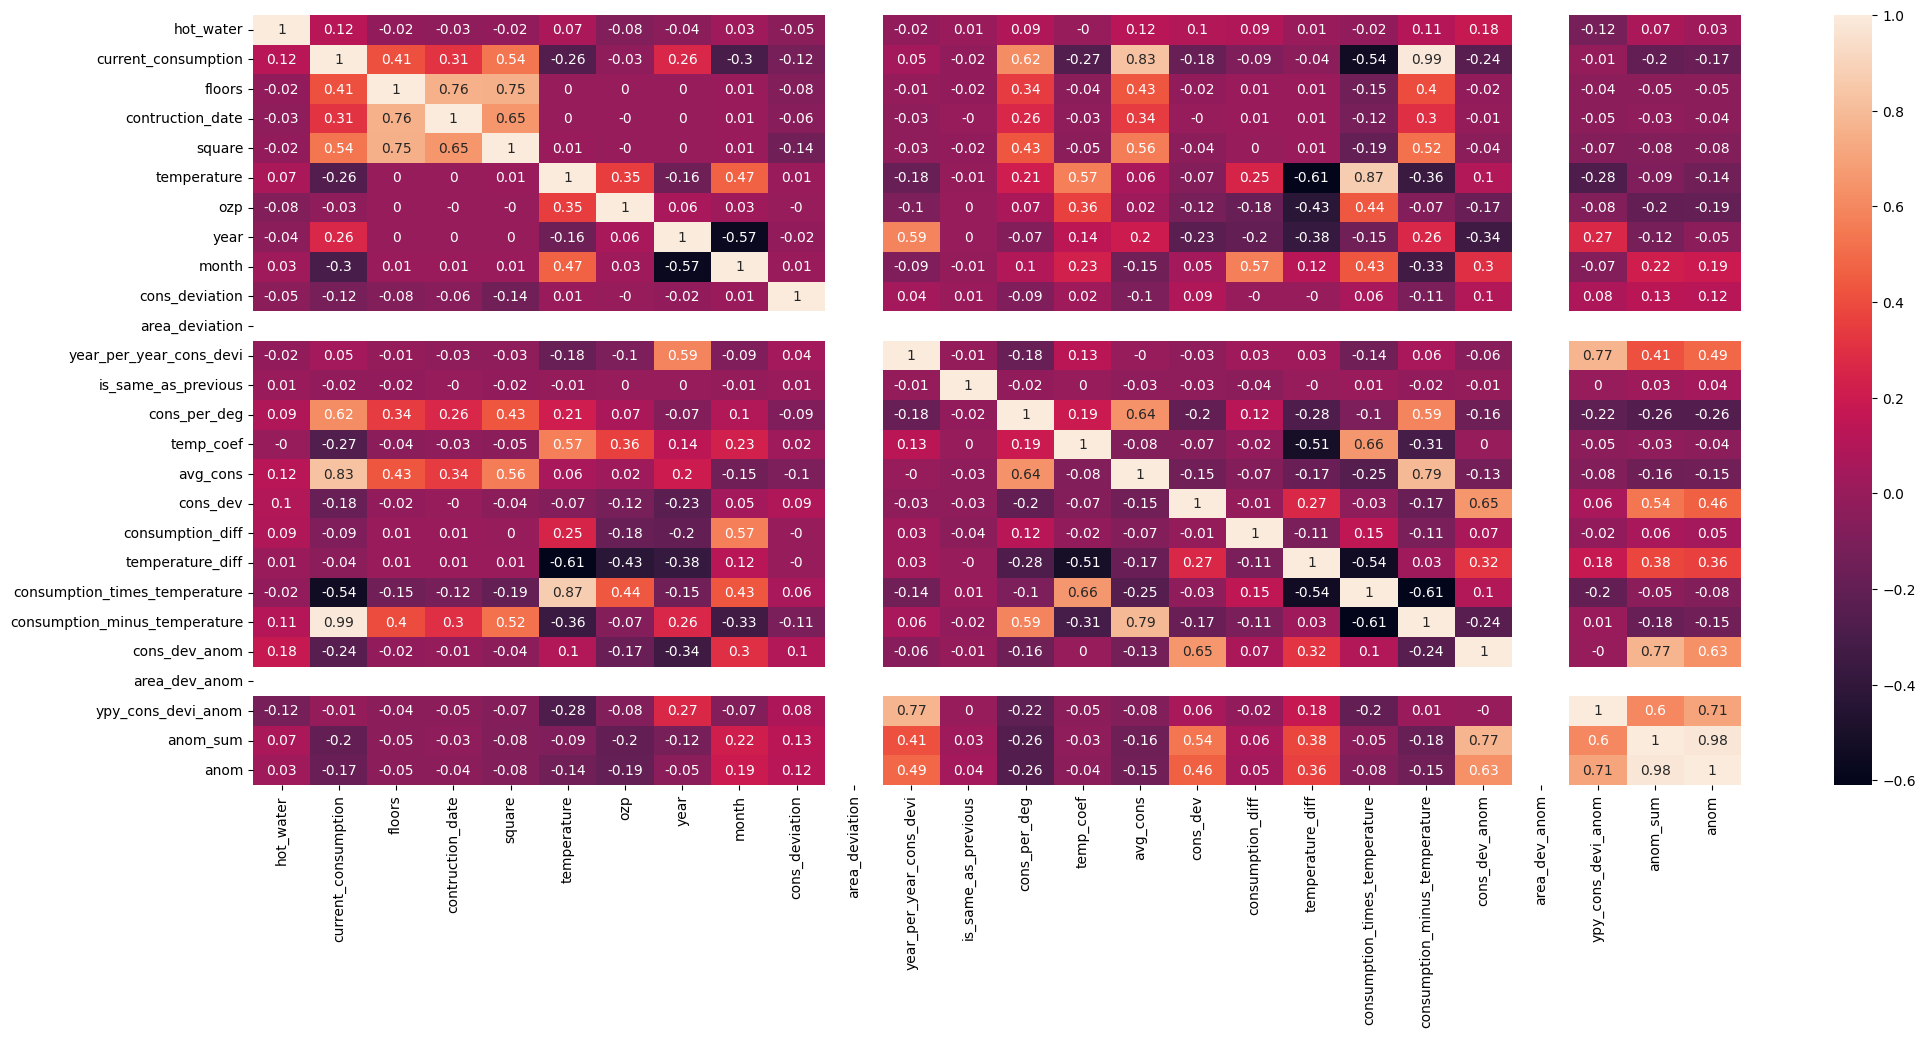

In [5]:
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(data_df.select_dtypes(include='number').corr(method='spearman'), 2), annot=True)

Посмотрим на нормальность признаков

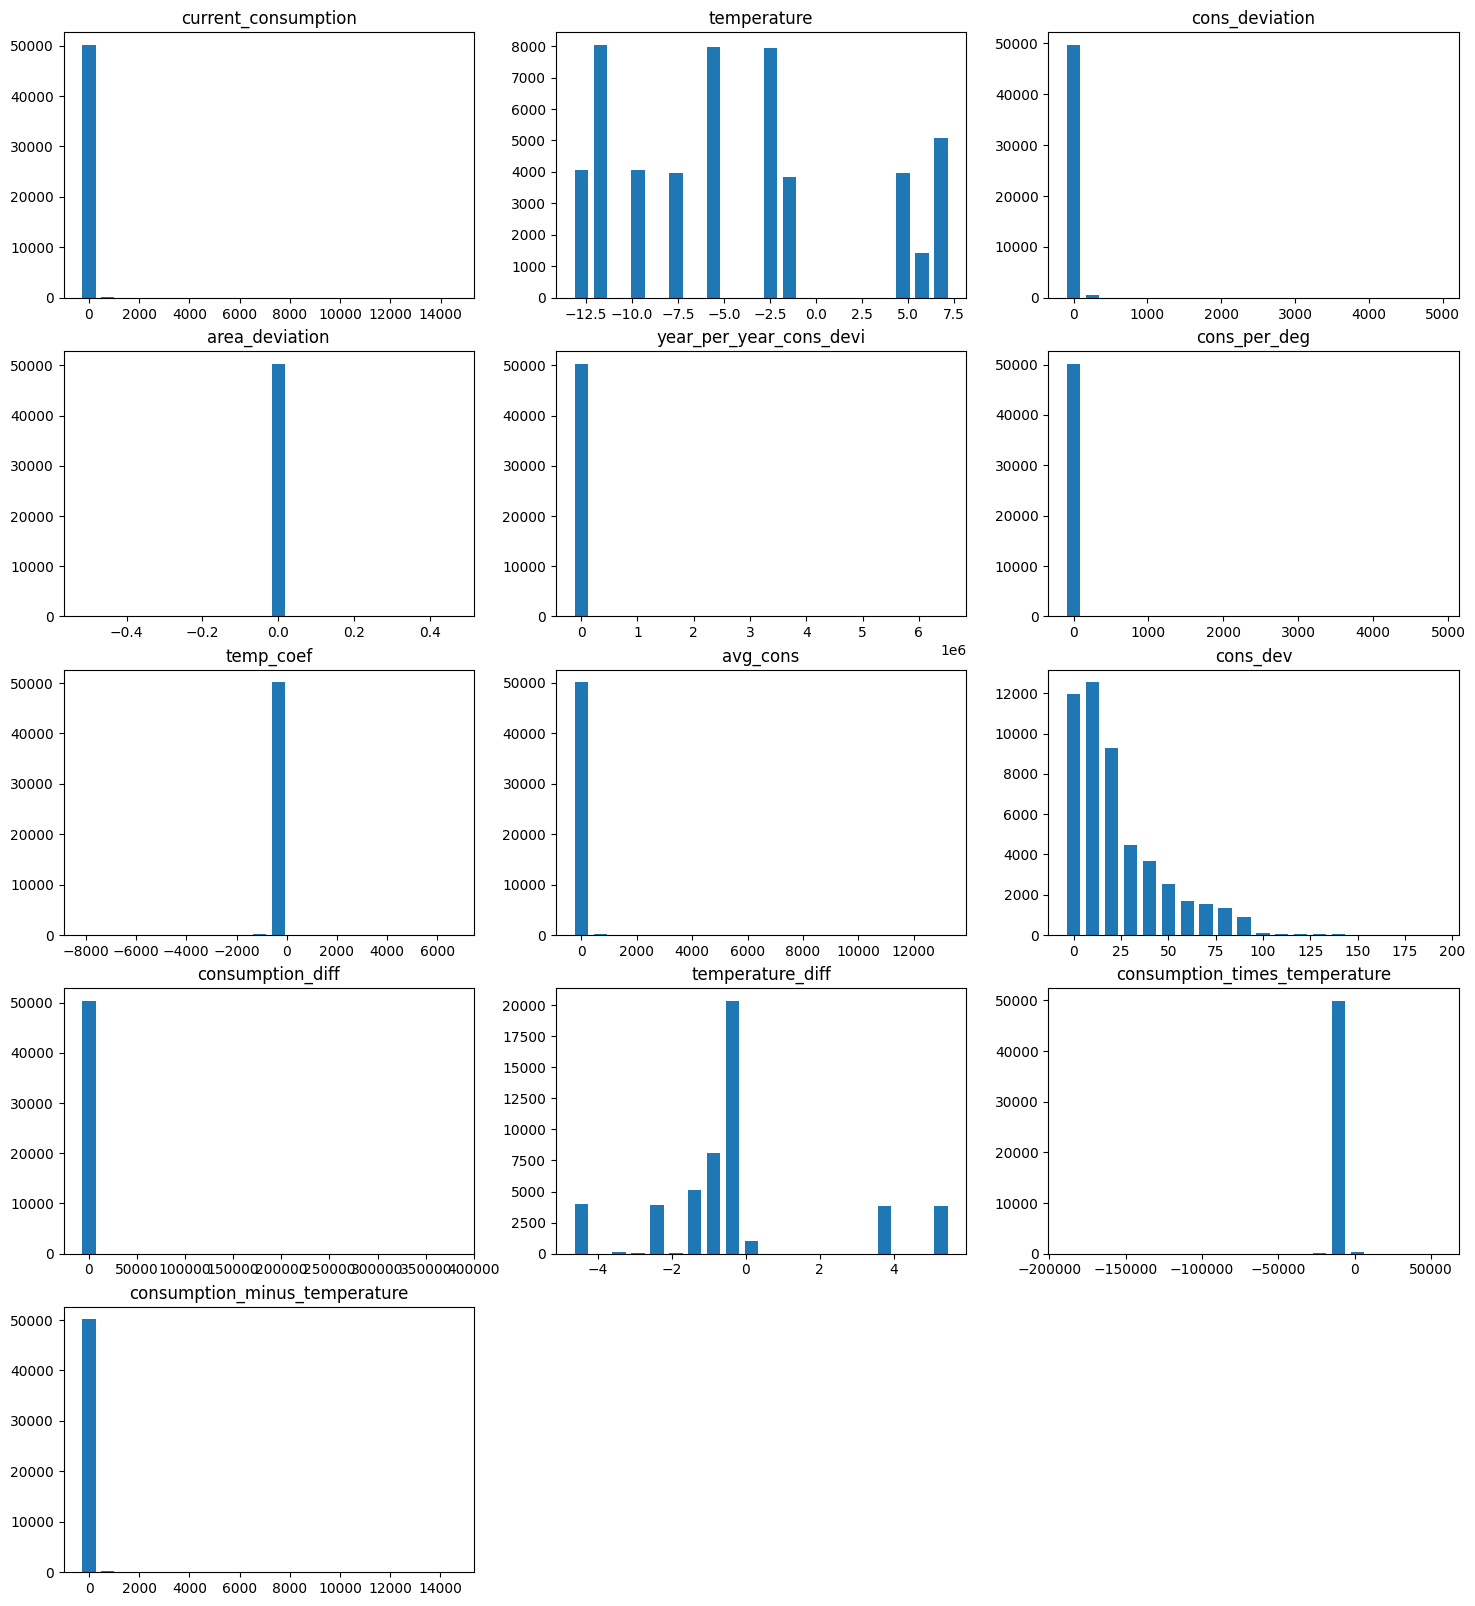

In [6]:
def visnormaldistrib(values):
  columns = min(3, len(values))
  rows = (len(values) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(values.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visnormaldistrib({'current_consumption': data_df['current_consumption'],
                  'temperature': data_df['temperature'],'cons_deviation': data_df['cons_deviation'],
                  'area_deviation': data_df['area_deviation'],'year_per_year_cons_devi': data_df['year_per_year_cons_devi'],
                  'cons_per_deg': data_df['cons_per_deg'],'temp_coef': data_df['temp_coef'],'avg_cons': data_df['avg_cons'],'cons_dev': data_df['cons_dev'],
                  'consumption_diff': data_df['consumption_diff'],'temperature_diff': data_df['temperature_diff'],'consumption_times_temperature': data_df['consumption_times_temperature'],
                  'consumption_minus_temperature': data_df['consumption_minus_temperature']})

Данные разряженные с большим колличеством выбросов, для нормализации лучше использовать RobustScaler. Приобразовывать категориальные признаки будем LabelEncoder

# <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Обучение моделей</div>

Распределение аномальных значений по типам объектов отличается. 'Многоквартирный дом' наиболее представленый тип объекта, разделим датафрейм на два и обучим две модели.

In [5]:
mask = (~data_df.address.str.contains('Подобъект|Подъезд')) & (data_df.object_type == 'Многоквартирный дом')
data_df.drop('address', axis=1,inplace=True)

In [6]:
df_mkd = data_df[mask]

In [7]:
df_other = data_df[~mask]

<ipython-input-10-033b40345282>:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df_mkd['anom'], sort = True)


Text(0, 0.5, 'Frequency')

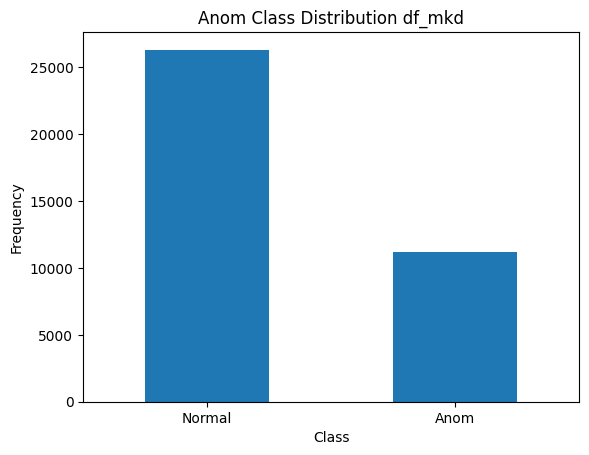

In [10]:
LABELS = ["Normal", "Anom"]

count_classes = pd.value_counts(df_mkd['anom'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Anom Class Distribution df_mkd")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

<ipython-input-11-35ea8e647f50>:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df_other['anom'], sort = True)


Text(0, 0.5, 'Frequency')

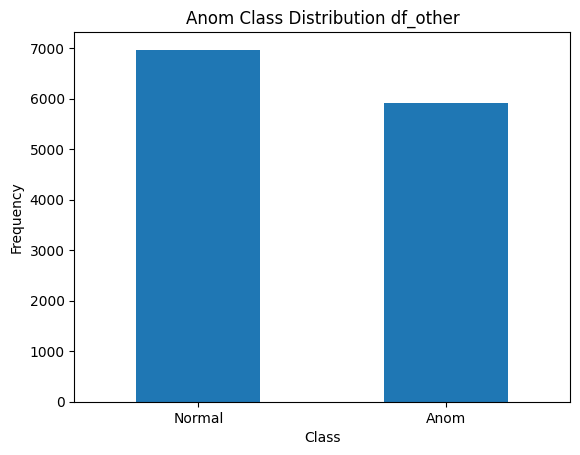

In [11]:
LABELS = ["Normal", "Anom"]

count_classes = pd.value_counts(df_other['anom'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Anom Class Distribution df_other")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

Нами было опробованно несколько моделей:IsolatreForest, XGBoost, RandomForest, LSTM, xLSTM. Лучшие результаты показала LSTM 3 слойная с регуляризацией и батчнормализация.

In [ ]:
# df_mkd.to_csv('combined_4_mkd_normR.csv', index=False)
# df_other.to_csv('combined_4_other_normR.csv', index=False)

In [8]:
gpu_strategy = tf.distribute.get_strategy()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> MKD (датасет с многоквартирными домами)</div>

In [ ]:
# data_normalized = pd.read_csv('combined_4_mkd_normR.csv')

In [9]:
data_normalized = df_mkd.copy()

In [10]:
categorical_features = data_normalized.select_dtypes(include=['object', 'category']).columns.tolist()
label_encoders = {feature: LabelEncoder() for feature in categorical_features}

for feature, le in label_encoders.items():
    data_normalized[feature] = le.fit_transform(data_normalized[feature])

scaler = RobustScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_normalized), columns=data_normalized.columns)

In [11]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]  # Исключаем последний столбец (метку аномалии)
        y = data[i+seq_length, -1]     # Метка аномалии
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50  # Длина временного окна
X, y = create_sequences(data_normalized.values, seq_length)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">LSTM 1L updated</div>

In [13]:
input_shape = (X_train.shape[1], X_train.shape[2])

model_1l = Sequential()
model_1l.add(Input(shape=input_shape))
model_1l.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model_1l.add(BatchNormalization())
model_1l.add(Dropout(0.3))

model_1l.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
model_1l.add(BatchNormalization())
model_1l.add(Dropout(0.3))

model_1l.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model_1l.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_1l.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_1l.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 128)             │          82,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,233 (528.25 KB)

 Trainable params: 134,849 (526.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [14]:
history_model_1l = model_1l.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7835 - loss: 0.6859 - val_accuracy: 0.8649 - val_loss: 0.4455
Epoch 2/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.8646 - loss: 0.4388 - val_accuracy: 0.8735 - val_loss: 0.3826
Epoch 3/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.8693 - loss: 0.3733 - val_accuracy: 0.8745 - val_loss: 0.3499
Epoch 4/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.8760 - loss: 0.3455 - val_accuracy: 0.8739 - val_loss: 0.3270
Epoch 5/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.8734 - loss: 0.3341 - val_accuracy: 0.8729 - val_loss: 0.3172
Epoch 6/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8784 - loss: 0.3203 - val_accuracy: 0.8792 - val_loss: 0.3091
Epoch 7/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.8794 - loss: 0.3180 - val_accuracy: 0.8829 - val_loss: 0.3027
Epoch 8/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8794 - loss: 0.3163 - 

In [15]:
y_pred_model_1l = model_1l.predict(X_test)
y_pred_model_1l = (y_pred_model_1l > 0.5).astype(int)

print(classification_report(y_test, y_pred_model_1l))


f1 = f1_score(y_test, y_pred_model_1l)
print(f'F1 Score: {f1}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93      5224
         1.0       0.86      0.79      0.83      2269

    accuracy                           0.90      7493
   macro avg       0.89      0.87      0.88      7493
weighted avg       0.90      0.90      0.90      7493

F1 Score: 0.8251716247139588


In [ ]:
# model_1l normalize Robust in colab
#               precision    recall  f1-score   support

#          0.0       0.92      0.94      0.93      5411
#          1.0       0.84      0.80      0.82      2188

#     accuracy                           0.90      7599
#    macro avg       0.88      0.87      0.88      7599
# weighted avg       0.90      0.90      0.90      7599

# F1 Score: 0.8219626168224299

# model_1l normalize MMS in colab

#               precision    recall  f1-score   support

#          0.0       0.92      0.92      0.92      5411
#          1.0       0.80      0.80      0.80      2188

#     accuracy                           0.88      7599
#    macro avg       0.86      0.86      0.86      7599
# weighted avg       0.89      0.88      0.88      7599

# model_1l F1 Score: 0.8006379585326954


# ________________________________________________________
# model_1l normalize robust out colab

#               precision    recall  f1-score   support

#          0.0       0.88      0.89      0.89      5411
#          1.0       0.72      0.70      0.71      2188

#     accuracy                           0.84      7599
#    macro avg       0.80      0.80      0.80      7599
# weighted avg       0.84      0.84      0.84      7599

# F1 Score: 0.7122969837587007
# model_1l normalize mms out colab
#               precision    recall  f1-score   support

#          0.0       0.83      0.92      0.87      5411
#          1.0       0.72      0.54      0.62      2188

#     accuracy                           0.81      7599
#    macro avg       0.78      0.73      0.74      7599
# weighted avg       0.80      0.81      0.80      7599

# F1 Score: 0.6157079064880483

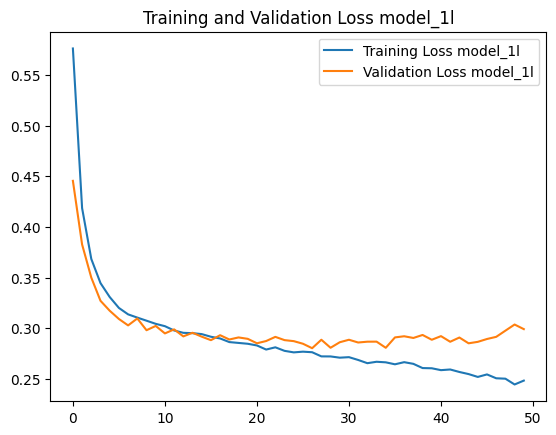

In [16]:
plt.plot(history_model_1l.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1l.history['val_loss'], label='Validation Loss model_1l')
plt.legend()
plt.title('Training and Validation Loss model_1l')
plt.show()

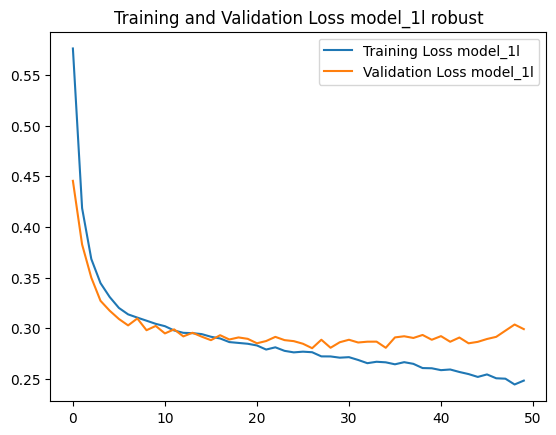

In [17]:
plt.plot(history_model_1l.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1l.history['val_loss'], label='Validation Loss model_1l')
plt.legend()
plt.title('Training and Validation Loss model_1l robust')
plt.show()

In [18]:
feature_names = data_df.columns.tolist()

# Получаем веса первого слоя
weights = model_1l.layers[0].get_weights()[0]

# Вычисляем абсолютные значения весов
abs_weights = np.abs(weights)

# Сортируем признаки по абсолютным значениям весов
feature_importance = np.sum(abs_weights, axis=1)
sorted_indices = np.argsort(feature_importance)[::-1]

# Выводим наиболее значимые признаки
for i in sorted_indices:
    print(f"Признак {feature_names[i]}: Важность {feature_importance[i]}")

Признак year_per_year_cons_devi: Важность 19.116220474243164
Признак consumption_diff: Важность 17.239238739013672
Признак cons_dev: Важность 13.11518383026123
Признак square: Важность 12.975564956665039
Признак avg_cons: Важность 12.410125732421875
Признак temperature_diff: Важность 11.993082046508789
Признак cons_deviation: Важность 11.368963241577148
Признак cons_per_deg: Важность 10.882795333862305
Признак ozp: Важность 10.78935432434082
Признак const_date_group: Важность 9.753791809082031
Признак contruction_date: Важность 9.671016693115234
Признак floors_group: Важность 9.649589538574219
Признак current_consumption: Важность 9.178784370422363
Признак temp_coef: Важность 8.906661987304688
Признак consumption_minus_temperature: Важность 8.871012687683105
Признак floors: Важность 8.762767791748047
Признак anom_sum: Важность 8.673617362976074
Признак hot_water: Важность 8.165453910827637
Признак street: Важность 7.906257629394531
Признак num_odpu: Важность 7.88961935043335
Признак co

In [51]:
model_1l.save('V_2_lstm_nornRUp_anomaly_detection_model.keras')

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">LSTM 2L updated</div>

In [19]:
input_shape = (X_train.shape[1], X_train.shape[2])

model_2l = Sequential()
model_2l.add(Input(shape=input_shape))
model_2l.add(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))
model_2l.add(BatchNormalization())
model_2l.add(Dropout(0.3))

model_2l.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model_2l.add(BatchNormalization())
model_2l.add(Dropout(0.3))

model_2l.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
model_2l.add(BatchNormalization())
model_2l.add(Dropout(0.3))

model_2l.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model_2l.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_2l.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_2l.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50, 256)             │         296,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 547,393 (2.09 MB)

 Trainable params: 546,497 (2.08 MB)

 Non-trainable params: 896 (3.50 KB)

In [20]:
history_model_2l = model_2l.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.7450 - loss: 1.0099 - val_accuracy: 0.8212 - val_loss: 0.5759
Epoch 2/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8608 - loss: 0.5007 - val_accuracy: 0.8715 - val_loss: 0.4011
Epoch 3/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8736 - loss: 0.3851 - val_accuracy: 0.8699 - val_loss: 0.3724
Epoch 4/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8651 - loss: 0.3665 - val_accuracy: 0.8619 - val_loss: 0.3553
Epoch 5/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8746 - loss: 0.3486 - val_accuracy: 0.8679 - val_loss: 0.3451
Epoch 6/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8768 - loss: 0.3324 - val_accuracy: 0.8739 - val_loss: 0.3331
Epoch 7/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8740 - loss: 0.3380 - val_accuracy: 0.8735 - val_loss: 0.3259
Epoch 8/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8791 - loss: 0.3189 - 

In [21]:
y_pred_model_2l = model_2l.predict(X_test)
y_pred_model_2l = (y_pred_model_2l > 0.5).astype(int)

print(classification_report(y_test, y_pred_model_2l))


f1 = f1_score(y_test, y_pred_model_2l)
print(f'F1 Score: {f1}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

         0.0       0.93      0.79      0.86      5224
         1.0       0.64      0.87      0.74      2269

    accuracy                           0.81      7493
   macro avg       0.79      0.83      0.80      7493
weighted avg       0.84      0.81      0.82      7493

F1 Score: 0.7391549295774648


In [ ]:
# model_2l normalize robust in colab
#               precision    recall  f1-score   support

#          0.0       0.92      0.94      0.93      5411
#          1.0       0.85      0.79      0.82      2188

#     accuracy                           0.90      7599
#    macro avg       0.88      0.87      0.88      7599
# weighted avg       0.90      0.90      0.90      7599

# F1 Score: 0.819966879583629

# model_2l normalize MMS in colab
#              precision    recall  f1-score   support

#          0.0       0.92      0.89      0.91      5411
#          1.0       0.75      0.82      0.78      2188

#     accuracy                           0.87      7599
#    macro avg       0.84      0.85      0.84      7599
# weighted avg       0.87      0.87      0.87      7599

# F1 Score: 0.7811816192560175

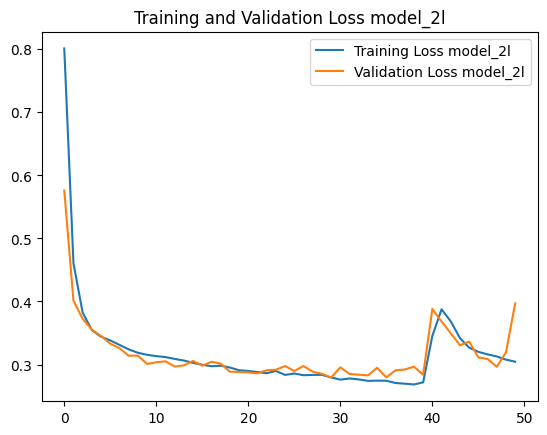

In [22]:
plt.plot(history_model_2l.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2l.history['val_loss'], label='Validation Loss model_2l')
plt.legend()
plt.title('Training and Validation Loss model_2l')
plt.show()

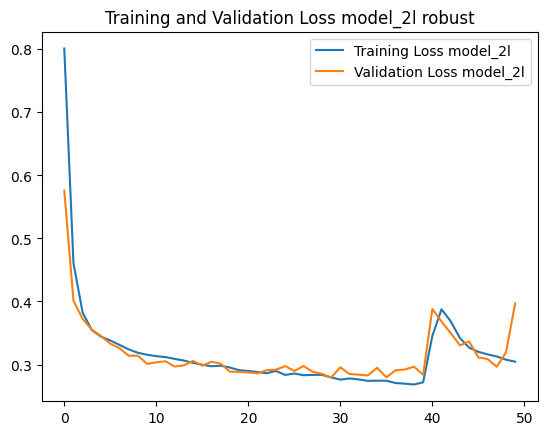

In [23]:
plt.plot(history_model_2l.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2l.history['val_loss'], label='Validation Loss model_2l')
plt.legend()
plt.title('Training and Validation Loss model_2l robust')
plt.show()

In [24]:
feature_names = data_df.columns.tolist()

# Получаем веса первого слоя
weights = model_2l.layers[0].get_weights()[0]

# Вычисляем абсолютные значения весов
abs_weights = np.abs(weights)

# Сортируем признаки по абсолютным значениям весов
feature_importance = np.sum(abs_weights, axis=1)
sorted_indices = np.argsort(feature_importance)[::-1]

# Выводим наиболее значимые признаки
for i in sorted_indices:
    print(f"Признак {feature_names[i]}: Важность {feature_importance[i]}")

Признак year_per_year_cons_devi: Важность 12.615667343139648
Признак consumption_diff: Важность 8.513286590576172
Признак avg_cons: Важность 5.361393928527832
Признак square: Важность 4.888908863067627
Признак cons_per_deg: Важность 4.437706470489502
Признак ozp: Важность 4.434899806976318
Признак hot_water: Важность 4.416932582855225
Признак contruction_date: Важность 3.956839084625244
Признак temperature_diff: Важность 3.621821165084839
Признак temperature: Важность 3.5973801612854004
Признак cons_dev: Важность 3.5753977298736572
Признак consumption_times_temperature: Важность 3.3281569480895996
Признак anom_sum: Важность 3.24200701713562
Признак const_date_group: Важность 3.1775026321411133
Признак date: Важность 3.1283249855041504
Признак ypy_cons_devi_anom: Важность 3.078200340270996
Признак year: Важность 3.0422141551971436
Признак temp_coef: Важность 3.038802146911621
Признак cons_deviation: Важность 3.0242676734924316
Признак current_consumption: Важность 2.727123737335205
Приз

In [ ]:
model_2l.save('lstm_2L_nornRUp_anomaly_detection_model.keras')

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Сравнение</div>

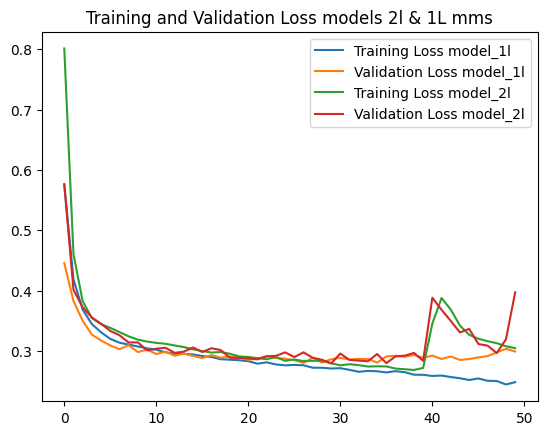

In [25]:
plt.plot(history_model_1l.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1l.history['val_loss'], label='Validation Loss model_1l')
plt.plot(history_model_2l.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2l.history['val_loss'], label='Validation Loss model_2l')

plt.legend()
plt.title('Training and Validation Loss models 2l & 1L mms')
plt.show()

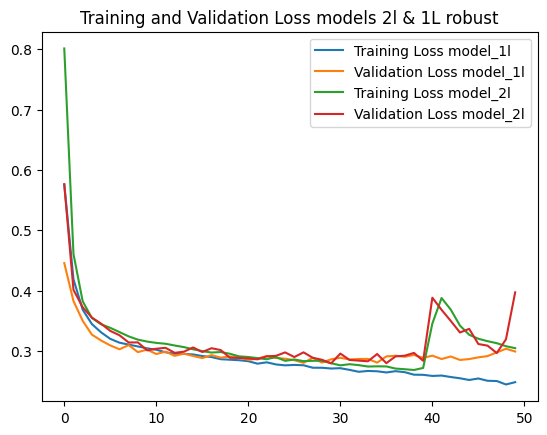

In [26]:
plt.plot(history_model_1l.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1l.history['val_loss'], label='Validation Loss model_1l')
plt.plot(history_model_2l.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2l.history['val_loss'], label='Validation Loss model_2l')

plt.legend()
plt.title('Training and Validation Loss models 2l & 1L robust')
plt.show()

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Датасет с где "все остальное"</div>

In [27]:
data_normalized2 = df_other.copy()

In [28]:
categorical_features = data_normalized2.select_dtypes(include=['object', 'category']).columns.tolist()
label_encoders = {feature: LabelEncoder() for feature in categorical_features}

for feature, le in label_encoders.items():
    data_normalized2[feature] = le.fit_transform(data_normalized2[feature])

scaler = RobustScaler()
data_normalized2 = pd.DataFrame(scaler.fit_transform(data_normalized2), columns=data_normalized2.columns)

In [29]:
seq_length = 50  # Длина временного окна
X, y = create_sequences(data_normalized.values, seq_length)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">LSTM 1L updated</div>

In [31]:
input_shapeO = (X_train.shape[1], X_train.shape[2])

model_1lO = Sequential()
model_1lO.add(Input(shape=input_shapeO))
model_1lO.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model_1lO.add(BatchNormalization())
model_1lO.add(Dropout(0.3))

model_1lO.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
model_1lO.add(BatchNormalization())
model_1lO.add(Dropout(0.3))

model_1lO.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model_1lO.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_1lO.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_1lO.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 50, 128)             │          82,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 50, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,233 (528.25 KB)

 Trainable params: 134,849 (526.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [32]:
history_model_1lO = model_1l.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9098 - loss: 0.2411 - val_accuracy: 0.8899 - val_loss: 0.2935
Epoch 2/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9110 - loss: 0.2402 - val_accuracy: 0.8936 - val_loss: 0.2914
Epoch 3/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9127 - loss: 0.2415 - val_accuracy: 0.8919 - val_loss: 0.3038
Epoch 4/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9137 - loss: 0.2349 - val_accuracy: 0.8926 - val_loss: 0.2973
Epoch 5/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9125 - loss: 0.2393 - val_accuracy: 0.8902 - val_loss: 0.3017
Epoch 6/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9129 - loss: 0.2410 - val_accuracy: 0.8849 - val_loss: 0.3222
Epoch 7/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9146 - loss: 0.2351 - val_accuracy: 0.8902 - val_loss: 0.3047
Epoch 8/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9155 - loss: 0.2344 - v

In [33]:
y_pred_model_1lO = model_1lO.predict(X_test)
y_pred_model_1lO = (y_pred_model_1lO > 0.5).astype(int)

print(classification_report(y_test, y_pred_model_1lO))


f1 = f1_score(y_test, y_pred_model_1lO)
print(f'F1 Score: {f1}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

         0.0       0.70      0.98      0.82      5224
         1.0       0.40      0.04      0.07      2269

    accuracy                           0.69      7493
   macro avg       0.55      0.51      0.44      7493
weighted avg       0.61      0.69      0.59      7493

F1 Score: 0.06548100242522231


In [ ]:
# model_1lO normolized roobust in colab
#               precision    recall  f1-score   support

#          0.0       0.56      0.77      0.65      1460
#          1.0       0.46      0.24      0.31      1157

#     accuracy                           0.54      2617
#    macro avg       0.51      0.51      0.48      2617
# weighted avg       0.52      0.54      0.50      2617

# F1 Score: 0.3132803632236095

# model_1lO normolized mms in colab
#               precision    recall  f1-score   support

#          0.0       0.49      0.11      0.18      1460
#          1.0       0.43      0.85      0.57      1157

#     accuracy                           0.44      2617
#    macro avg       0.46      0.48      0.38      2617
# weighted avg       0.46      0.44      0.36      2617

# F1 Score: 0.5723435225618632

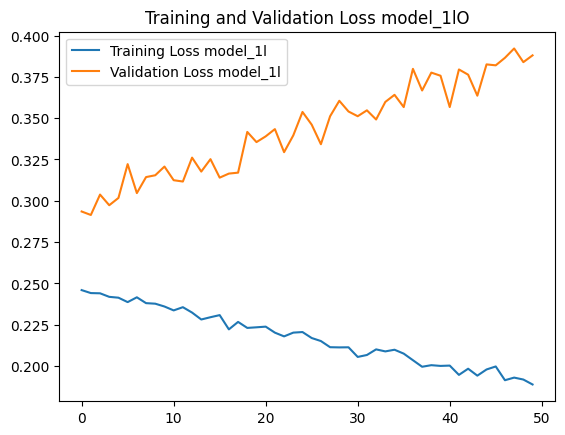

In [34]:
plt.plot(history_model_1lO.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1lO.history['val_loss'], label='Validation Loss model_1l')
plt.legend()
plt.title('Training and Validation Loss model_1lO')
plt.show()

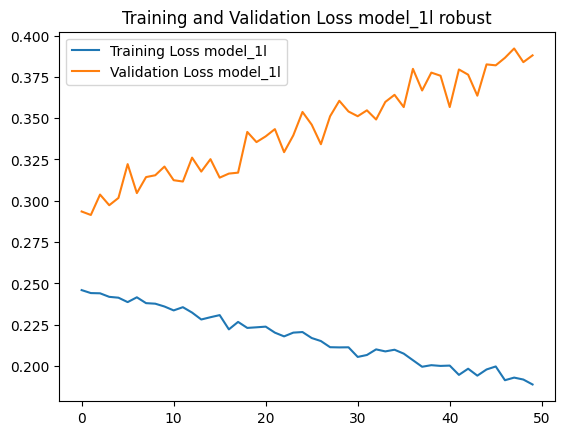

In [35]:
plt.plot(history_model_1lO.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1lO.history['val_loss'], label='Validation Loss model_1l')
plt.legend()
plt.title('Training and Validation Loss model_1l robust')
plt.show()

In [36]:
feature_names = data_df.columns.tolist()

# Получаем веса первого слоя
weights = model_1lO.layers[0].get_weights()[0]

# Вычисляем абсолютные значения весов
abs_weights = np.abs(weights)

# Сортируем признаки по абсолютным значениям весов
feature_importance = np.sum(abs_weights, axis=1)
sorted_indices = np.argsort(feature_importance)[::-1]

# Выводим наиболее значимые признаки
for i in sorted_indices:
    print(f"Признак {feature_names[i]}: Важность {feature_importance[i]}")

Признак cons_dev: Важность 28.10442352294922
Признак num_odpu: Важность 27.911266326904297
Признак year_per_year_cons_devi: Важность 27.75021743774414
Признак is_same_as_previous: Важность 27.674938201904297
Признак year: Важность 27.571491241455078
Признак street: Важность 27.436405181884766
Признак temp_coef: Важность 27.373146057128906
Признак floors_group: Важность 27.36437225341797
Признак consumption_minus_temperature: Важность 27.311634063720703
Признак square: Важность 27.277976989746094
Признак area_dev_anom: Важность 27.261646270751953
Признак cons_deviation: Важность 27.247108459472656
Признак ypy_cons_devi_anom: Важность 27.23644256591797
Признак floors: Важность 27.222942352294922
Признак hot_water: Важность 27.128150939941406
Признак contruction_date: Важность 26.905006408691406
Признак object_type: Важность 26.855613708496094
Признак month: Важность 26.85281753540039
Признак area_deviation: Важность 26.805395126342773
Признак const_date_group: Важность 26.800334930419922

In [ ]:
# model_1lO.save('lstm_OTHER_1L_normMmsUp_anomaly_detection_model.keras')
model_1lO.save('lstm_OTHER_1L_nornRUp_anomaly_detection_model.keras')

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">LSTM 2L updated</div>

In [37]:
input_shapeO = (X_train.shape[1], X_train.shape[2])

model_2lO = Sequential()
model_2lO.add(Input(shape=input_shapeO))
model_2lO.add(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))
model_2lO.add(BatchNormalization())
model_2lO.add(Dropout(0.3))

model_2lO.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model_2lO.add(BatchNormalization())
model_2lO.add(Dropout(0.3))

model_2lO.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
model_2lO.add(BatchNormalization())
model_2lO.add(Dropout(0.3))

model_2lO.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model_2lO.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_2lO.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_2lO.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 50, 256)             │         296,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 50, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 50, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 50, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 547,393 (2.09 MB)

 Trainable params: 546,497 (2.08 MB)

 Non-trainable params: 896 (3.50 KB)

In [38]:
history_model_2lO = model_2l.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8723 - loss: 0.3135 - val_accuracy: 0.8805 - val_loss: 0.2940
Epoch 2/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8798 - loss: 0.3029 - val_accuracy: 0.8822 - val_loss: 0.2962
Epoch 3/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8763 - loss: 0.3007 - val_accuracy: 0.8789 - val_loss: 0.2974
Epoch 4/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8802 - loss: 0.3027 - val_accuracy: 0.8846 - val_loss: 0.2886
Epoch 5/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8820 - loss: 0.2964 - val_accuracy: 0.8896 - val_loss: 0.2911
Epoch 6/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8776 - loss: 0.3002 - val_accuracy: 0.8789 - val_loss: 0.3024
Epoch 7/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8836 - loss: 0.2970 - val_accuracy: 0.8308 - val_loss: 0.4140
Epoch 8/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8797 - loss: 0.2999 - 

In [39]:
y_pred_model_2lO = model_2lO.predict(X_test)
y_pred_model_2lO = (y_pred_model_2lO > 0.5).astype(int)

print(classification_report(y_test, y_pred_model_2lO))


f1 = f1_score(y_test, y_pred_model_2lO)
print(f'F1 Score: {f1}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

         0.0       0.69      0.14      0.24      5224
         1.0       0.30      0.85      0.45      2269

    accuracy                           0.36      7493
   macro avg       0.50      0.50      0.34      7493
weighted avg       0.57      0.36      0.30      7493

F1 Score: 0.4462600690448792


In [ ]:
#model_2lO normolized robust in colab
#               precision    recall  f1-score   support

#          0.0       0.56      0.09      0.16      1460
#          1.0       0.44      0.91      0.60      1157

#     accuracy                           0.45      2617
#    macro avg       0.50      0.50      0.38      2617
# weighted avg       0.51      0.45      0.35      2617

# F1 Score: 0.5950226244343891

#model_2lO normolized mms in colab
#               precision    recall  f1-score   support

#          0.0       0.56      1.00      0.72      1460
#          1.0       1.00      0.00      0.00      1157

#     accuracy                           0.56      2617
#    macro avg       0.78      0.50      0.36      2617
# weighted avg       0.75      0.56      0.40      2617

# F1 Score: 0.003451251078515962

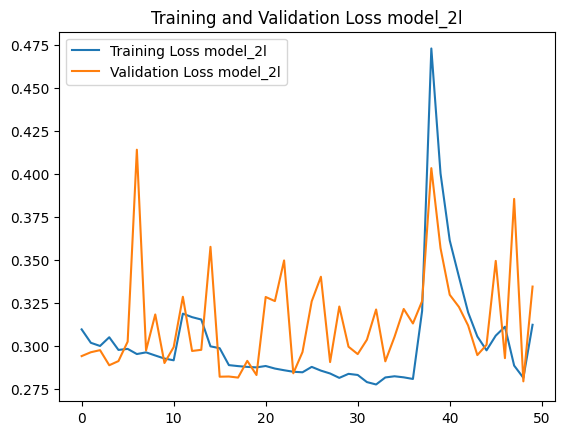

In [40]:
plt.plot(history_model_2lO.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2lO.history['val_loss'], label='Validation Loss model_2l')
plt.legend()
plt.title('Training and Validation Loss model_2l')
plt.show()

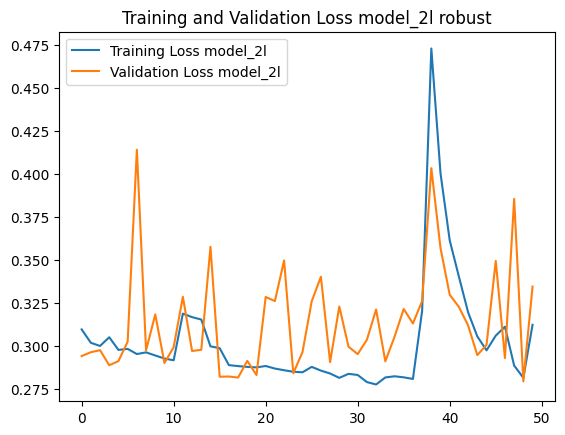

In [41]:
plt.plot(history_model_2lO.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2lO.history['val_loss'], label='Validation Loss model_2l')
plt.legend()
plt.title('Training and Validation Loss model_2l robust')
plt.show()

In [42]:
feature_names = data_df.columns.tolist()

# Получаем веса первого слоя
weights = model_2lO.layers[0].get_weights()[0]

# Вычисляем абсолютные значения весов
abs_weights = np.abs(weights)

# Сортируем признаки по абсолютным значениям весов
feature_importance = np.sum(abs_weights, axis=1)
sorted_indices = np.argsort(feature_importance)[::-1]

# Выводим наиболее значимые признаки
for i in sorted_indices:
    print(f"Признак {feature_names[i]}: Важность {feature_importance[i]}")

Признак month: Важность 39.67211151123047
Признак city: Важность 39.62189483642578
Признак temp_coef: Важность 39.56830596923828
Признак ypy_cons_devi_anom: Важность 39.375205993652344
Признак area_dev_anom: Важность 39.34425354003906
Признак contruction_date: Важность 39.271244049072266
Признак year_per_year_cons_devi: Важность 39.251869201660156
Признак cons_deviation: Важность 39.20511245727539
Признак avg_cons: Важность 39.17646408081055
Признак cons_dev_anom: Важность 39.14384460449219
Признак current_consumption: Важность 39.086524963378906
Признак temperature: Важность 39.08075714111328
Признак floors_group: Важность 39.028167724609375
Признак year: Важность 39.02705383300781
Признак hot_water: Важность 38.89837646484375
Признак num_odpu: Важность 38.877471923828125
Признак consumption_times_temperature: Важность 38.86894226074219
Признак area_deviation: Важность 38.70472717285156
Признак const_date_group: Важность 38.679874420166016
Признак street: Важность 38.67062759399414
Пр

In [ ]:
# model_2lO.save('lstm_OTHER_2L_normMmsUp_anomaly_detection_model.keras')
model_2lO.save('lstm_OTHER_2L_nornRUp_anomaly_detection_model.keras')

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Simple SLTM</div>

In [43]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7960 - loss: 0.4354 - val_accuracy: 0.8689 - val_loss: 0.3034
Epoch 2/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8741 - loss: 0.2945 - val_accuracy: 0.8745 - val_loss: 0.2887
Epoch 3/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8785 - loss: 0.2813 - val_accuracy: 0.8856 - val_loss: 0.2774
Epoch 4/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8836 - loss: 0.2728 - val_accuracy: 0.8802 - val_loss: 0.2775
Epoch 5/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8867 - loss: 0.2606 - val_accuracy: 0.8882 - val_loss: 0.2645
Epoch 6/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8929 - loss: 0.2456 - val_accuracy: 0.8839 - val_loss: 0.2643
Epoch 7/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8940 - loss: 0.2447 - val_accuracy: 0.8859 - val_loss: 0.2583
Epoch 8/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9005 - loss: 0.2310 - val_accu

In [45]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      5224
         1.0       0.81      0.77      0.79      2269

    accuracy                           0.87      7493
   macro avg       0.85      0.85      0.85      7493
weighted avg       0.87      0.87      0.87      7493

F1 Score: 0.7881107858590407


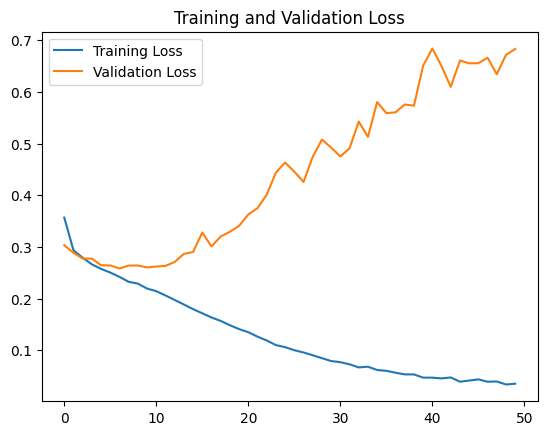

In [46]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [52]:
model.save('V_2_lstm_simple_nornRUp_anomaly_detection_model.keras')

In [47]:
feature_names = data_df.columns.tolist()

# Получаем веса первого слоя
weights = model.layers[0].get_weights()[0]

# Вычисляем абсолютные значения весов
abs_weights = np.abs(weights)

# Сортируем признаки по абсолютным значениям весов
feature_importance = np.sum(abs_weights, axis=1)
sorted_indices = np.argsort(feature_importance)[::-1]

# Выводим наиболее значимые признаки
for i in sorted_indices:
    print(f"Признак {feature_names[i]}: Важность {feature_importance[i]}")

Признак is_same_as_previous: Важность 218.517822265625
Признак city: Важность 209.14044189453125
Признак street: Важность 185.8968505859375
Признак cons_dev: Важность 179.16098022460938
Признак ypy_cons_devi_anom: Важность 142.857177734375
Признак year_per_year_cons_devi: Важность 132.71287536621094
Признак num_odpu: Важность 131.87753295898438
Признак consumption_diff: Важность 130.1768035888672
Признак hot_water: Важность 121.4385986328125
Признак cons_dev_anom: Важность 117.45829010009766
Признак anom_sum: Важность 116.15652465820312
Признак cons_per_deg: Важность 111.0963134765625
Признак square: Важность 110.62144470214844
Признак floors_group: Важность 109.4234390258789
Признак cons_deviation: Важность 108.5670166015625
Признак avg_cons: Важность 107.603271484375
Признак temp_coef: Важность 107.0654296875
Признак floors: Важность 106.3226318359375
Признак contruction_date: Важность 103.71680450439453
Признак temperature: Важность 103.302978515625
Признак temperature_diff: Важност

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Сравнение</div>

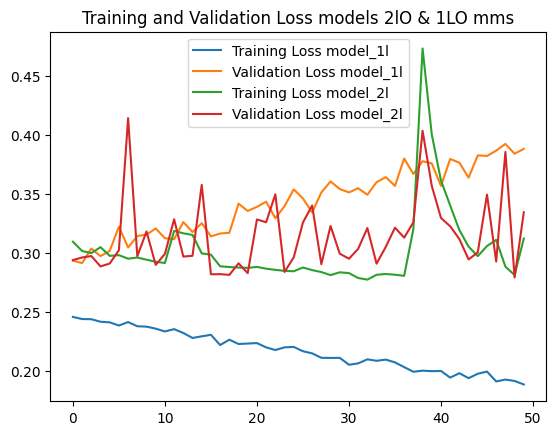

In [48]:
plt.plot(history_model_1lO.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1lO.history['val_loss'], label='Validation Loss model_1l')
plt.plot(history_model_2lO.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2lO.history['val_loss'], label='Validation Loss model_2l')

plt.legend()
plt.title('Training and Validation Loss models 2lO & 1LO mms')
plt.show()

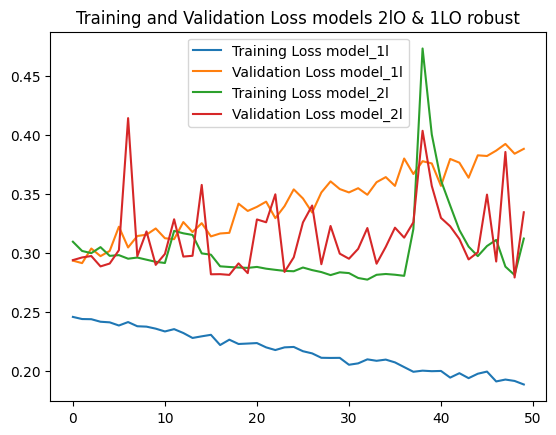

In [49]:
plt.plot(history_model_1lO.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1lO.history['val_loss'], label='Validation Loss model_1l')
plt.plot(history_model_2lO.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2lO.history['val_loss'], label='Validation Loss model_2l')

plt.legend()
plt.title('Training and Validation Loss models 2lO & 1LO robust')
plt.show()

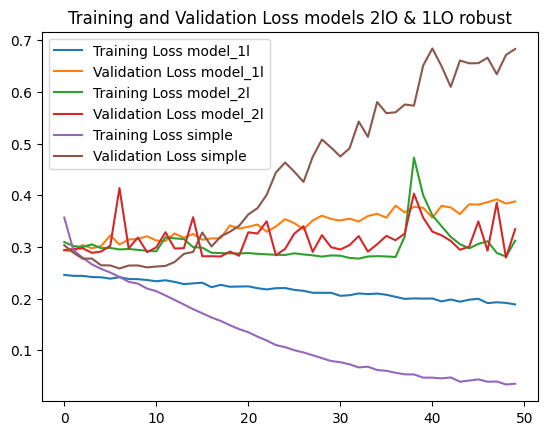

In [50]:
plt.plot(history_model_1lO.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1lO.history['val_loss'], label='Validation Loss model_1l')
plt.plot(history_model_2lO.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2lO.history['val_loss'], label='Validation Loss model_2l')
plt.plot(history.history['loss'], label='Training Loss simple')
plt.plot(history.history['val_loss'], label='Validation Loss simple')
plt.legend()
plt.title('Training and Validation Loss models 2lO & 1LO robust')
plt.show()

# <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Выгрузка результатов предсказаний</div>

In [ ]:
model.load('lstm_normRUp_anomaly_detection_model.h5') # лучшая модель для многоквартирных домов
# model.load('lstm_simple_nornRUp_anomaly_detection_model.h5') # лучшая модель для всего остального

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = (y_pred > 0.5).astype(int)  # Преобразуем вероятности в метки классов

In [ ]:
#создаем датафрейм с предсказаниями
y_test_df = pd.DataFrame(y_test, columns=['true_class'])
y_pred_df = pd.DataFrame(y_pred, columns=['predicted_class'])
result_df = pd.concat([y_test_df, y_pred_df], axis=1)

In [ ]:
#Возврат преобразованных категориальных признаков обратно в исходный вид
for feature, le in label_encoders.items():
    df[feature] = le.inverse_transform(df[feature])

In [ ]:
anomalies_df = pd.concat([df.iloc[-len(y_test):].reset_index(), result_df], axis=1)

In [ ]:
anomalies_df.to_excel('anomalies.xlsx',sheet_name='аномалии', index=False)